In [251]:
import numpy as np
import matplotlib.pyplot as plt
import time

##Paramètres
mu = 30e9
sigma = 100e6
rho = 2400

a = 2e-4
b = 1e-3
v0 = 1e-9
dc = 1e-3
taubdot = 1e-2 #Pa.s-1

eta = np.sqrt(mu*rho/2) #=6000000
Lb = mu*dc/(b*sigma) #=300

alpha = a/b 
beta = eta*v0/(b*sigma) #=6e-08
taubbardot = 0#dc*taubdot/(b*sigma*v0) #=0.1

deltaX = int(Lb/4) #=75
#deltaX < Lb
#L > Lb
N = 10000
I = 128
L = I * deltaX
h = 1e-2


##Calcul du gradient de la transformée de Hilbert (cf. doc)
def hilbert_grad(f, deltaX) :
    """
    Renvoie la transformée de Hilbert du gradient par rapport à l'espace de la fonction f
    f est un tableau de taille I qui représente f à un instant en tout point
    """
    F=np.fft.fft(f)
    k=np.fft.fftfreq(len(f),deltaX)

    F=np.abs(k*2*np.pi)*F

    hh=np.fft.ifft(F)
    return hh.real*Lb

##Résolution numérique de l'équation différentielle (cf. doc)
def RKF(f, yk, h=1e-2, dtmin=1e-16, dtmax=1e2, tol=1e-10):
    K = 0
    t0 = time.time()
    if h > dtmax:   #Cela empêche la fonction de marcher si c'est le cas.
        h = dtmax/2
    s = 1.
    ykk = yk
    while s*h < dtmax and K < 30:
        k1 = h * f(yk)
        k2 = h * f(yk + k1/4)
        k3 = h * f(yk + 3*k1/32 + 9*k2/32)
        k4 = h * f(yk + 1932*k1/2197 - 7200*k2/2197 + 7296*k3/2197)
        k5 = h * f(yk + 439*k1/216 - 8*k2 + 3680*k3/513 - 845*k4/4104)
        k6 = h * f(yk - 8*k1/27 + 2*k2 - 3544*k3/2565 + 1859*k4/4104 - 11*k5/40)
        ykk = yk + 25*k1/216 + 1408*k3/2565 + 2197*k4/4104 - k5/5
        #print('ykk='+str(ykk))
        zkk = yk + 16*k1/135 + 6656*k3/12825 + 28561*k4/56430 - 9*k5/50 + 2*k6/55
        erreur = np.linalg.norm(zkk - ykk)
        tf = time.time()
        K = K +1
        if erreur < tol:
            print(tf-t0)
            return ykk, h
        s = (h / (2 * erreur))**0.25
        if s*h < dtmin:
            print(tf-t0)
            return ykk, h
        h = s*h
        print(tf-t0)
    return ykk, h

##Système différentiel
def phidot(phi, nu):
    v = np.exp(phi)
    theta = np.exp(nu)
    H = hilbert_grad(v, deltaX)
    return (v - 1/theta - 1/2*H + taubbardot*np.ones(I+1))/(alpha+beta*v)
    
def nudot(phi, nu):
    v = np.exp(phi)
    theta = np.exp(nu)
    return 1/theta - v

def F(y):
    phi = y[0]
    nu = y[1]
    F1 = phidot(phi, nu)
    F2 = nudot(phi, nu)
    return np.array([F1, F2])


##Conditions initiales
x = np.arange(-L//2, L//2 + 1, deltaX)
d = 500 #largeur de la zone de glissemnt initiale
amp = 50 #amplitude max

#Elliptique
Ae = []
for y in x :
    if y < d and y > -d:
        Ae.append((np.sqrt(d**2 - y**2)/d)*amp + 1)
    else :
        Ae.append(1)
        
Ae = np.array(Ae)
Be = 1/Ae

#Gaussienne
Ag = np.exp(-x**2/(d*500))*amp + np.ones(I+1)
Bg = 1/Ag

#Carré
Ac = []
for y in x :
    if y < d and y > -d:
        Ac.append(amp)
    else :
        Ac.append(1)

Ac = np.array(Ac)
Bc = 1/Ac

#Uniformes
Au = np.ones(I+1)*amp
Bu = 1/Au

##Résolution
CIv = Ae
CItheta = Be

phik = np.log(CIv)
nuk = np.log(CItheta)

yk = np.array([phik, nuk])

Phi = [phik]
Nu = [nuk]

for n in range(N):
    if n%10 == 0:
        print(n)
    res = RKF(F, yk, h)
    yk = res[0]
    h = res[1]
    Phi.append(yk[0])
    Nu.append(yk[1])

0
0.0027577877044677734
0.005053281784057617
0.00989985466003418
0.012722253799438477
0.014751911163330078
0.0163116455078125
0.0163116455078125
0.0163116455078125
0.021954059600830078
0.023949861526489258
0.025562763214111328
0.025562763214111328
0.025562763214111328
0.025562763214111328
0.025562763214111328
0.035314083099365234
0.036312103271484375
0.03954172134399414
0.04055023193359375
0.04055023193359375
0.04055023193359375
0.05469155311584473
0.056897878646850586
0.056897878646850586
0.056897878646850586
0.056897878646850586
0.056897878646850586
0.056897878646850586
0.056897878646850586
0.07168912887573242
0.001992464065551758
0.001992464065551758
0.001992464065551758
0.001992464065551758
0.001992464065551758
0.001992464065551758
0.001992464065551758
0.001992464065551758
0.001992464065551758
0.017984628677368164
0.017984628677368164
0.017984628677368164
0.017984628677368164
0.017984628677368164
0.017984628677368164
0.017984628677368164
0.017984628677368164
0.017984628677368164
0.

0.04679608345031738
0.052903175354003906
0.053897857666015625
0.053897857666015625
0.053897857666015625
0.053897857666015625
0.053897857666015625
0.0020368099212646484
0.0020368099212646484
0.005361080169677734
0.007187843322753906
0.009104251861572266
0.011541366577148438
0.01253819465637207
0.01253819465637207
0.016710996627807617
0.019133329391479492
0.02013254165649414
0.02013254165649414
0.02013254165649414
0.02013254165649414
0.02013254165649414
0.02013254165649414
0.02013254165649414
0.02013254165649414
0.03591179847717285
0.03792142868041992
0.03792142868041992
0.03792142868041992
0.03792142868041992
0.04447674751281738
0.04447674751281738
0.04447674751281738
0.05026555061340332
0.0522615909576416
0.0522615909576416
0.0522615909576416
0.0
0.0
0.0
0.0
0.0
0.014365196228027344
0.016361236572265625
0.016361236572265625
0.016361236572265625
0.016361236572265625
0.016361236572265625
0.016361236572265625
0.016361236572265625
0.016361236572265625
0.016361236572265625
0.032062530517578

0.049978017807006836
0.053734540939331055
0.05473160743713379
0.05473160743713379
0.05473160743713379
0.06128287315368652
0.06128287315368652
0.06128287315368652
0.0666961669921875
0.0
0.0
0.004393100738525391
0.00689697265625
0.009108781814575195
0.01114654541015625
0.01114654541015625
0.01114654541015625
0.01782846450805664
0.020819425582885742
0.020819425582885742
0.020819425582885742
0.020819425582885742
0.03346061706542969
0.03445768356323242
0.03445768356323242
0.03445768356323242
0.03445768356323242
0.03445768356323242
0.03445768356323242
0.04924511909484863
0.05029177665710449
0.05029177665710449
0.05029177665710449
0.05029177665710449
0.05029177665710449
0.05029177665710449
0.05029177665710449
0.05029177665710449
0.06654548645019531
0.0010006427764892578
0.0010006427764892578
0.0010006427764892578
0.0010006427764892578
0.0010006427764892578
0.0010006427764892578
0.0010006427764892578
0.0010006427764892578
0.014735937118530273
0.016777753829956055
0.016777753829956055
0.0167777

0.05131030082702637
0.0547482967376709
0.055748939514160156
0.055748939514160156
0.055748939514160156
0.055748939514160156
0.055748939514160156
0.065704345703125
0.0010333061218261719
0.0010333061218261719
0.005518674850463867
0.007220745086669922
0.009698152542114258
0.010725975036621094
0.011724233627319336
0.011724233627319336
0.011724233627319336
0.01832270622253418
0.019318103790283203
0.019318103790283203
0.019318103790283203
0.019318103790283203
0.019318103790283203
0.019318103790283203
0.019318103790283203
0.03329920768737793
0.03529620170593262
0.03529620170593262
0.03529620170593262
0.03529620170593262
0.03529620170593262
0.03529620170593262
0.04586648941040039
0.04586648941040039
0.04991507530212402
0.050911903381347656
0.050911903381347656
0.050911903381347656
0.0
0.0
0.0
0.0
0.0
0.0
0.016663789749145508
0.017660856246948242
0.017660856246948242
0.017660856246948242
0.017660856246948242
0.017660856246948242
0.017660856246948242
0.017660856246948242
0.017660856246948242
0.03

0.05000114440917969
0.05580592155456543
0.05680203437805176
0.05680203437805176
0.05680203437805176
0.06185603141784668
0.06185603141784668
0.06679058074951172
0.06679058074951172
0.07076311111450195
0.0017902851104736328
0.003070831298828125
0.005422830581665039
0.006452798843383789
0.006452798843383789
0.006452798843383789
0.013673067092895508
0.014670610427856445
0.014670610427856445
0.014670610427856445
0.014670610427856445
0.014670610427856445
0.014670610427856445
0.014670610427856445
0.014670610427856445
0.02932262420654297
0.030353784561157227
0.030353784561157227
0.030353784561157227
0.030353784561157227
0.030353784561157227
0.030353784561157227
0.030353784561157227
0.030353784561157227
0.04590797424316406
0.04590797424316406
0.04590797424316406
0.04590797424316406
0.04590797424316406
0.04590797424316406
0.0
0.0
0.0
0.01563715934753418
0.016634702682495117
0.016634702682495117
0.016634702682495117
0.016634702682495117
0.016634702682495117
0.016634702682495117
0.0166347026824951

0.06664085388183594
0.0018529891967773438
0.002848386764526367
0.002848386764526367
0.002848386764526367
0.002848386764526367
0.002848386764526367
0.012408971786499023
0.012408971786499023
0.015677452087402344
0.01752185821533203
0.019664287567138672
0.02100372314453125
0.022003889083862305
0.022003889083862305
0.022003889083862305
0.030052900314331055
0.031049251556396484
0.031049251556396484
0.031049251556396484
0.031049251556396484
0.031049251556396484
0.031049251556396484
0.031049251556396484
0.031049251556396484
0.04564714431762695
0.0466456413269043
0.0466456413269043
0.0466456413269043
0.0466456413269043
0.0466456413269043
0.0
0.011542081832885742
0.011542081832885742
0.01564955711364746
0.01564955711364746
0.01564955711364746
0.01564955711364746
0.01564955711364746
0.01564955711364746
0.01564955711364746
0.01564955711364746
0.01564955711364746
0.031313419342041016
0.032311201095581055
0.032311201095581055
0.032311201095581055
0.032311201095581055
0.032311201095581055
0.03231120

0.05244731903076172
0.05432438850402832
0.055320024490356445
0.055320024490356445
0.055320024490356445
0.055320024490356445
0.0
0.0033292770385742188
0.004324674606323242
0.0073854923248291016
0.009163141250610352
0.011189937591552734
0.013184070587158203
0.013184070587158203
0.013184070587158203
0.018965959548950195
0.02115941047668457
0.022159337997436523
0.022159337997436523
0.022159337997436523
0.022159337997436523
0.022159337997436523
0.022159337997436523
0.022159337997436523
0.03563117980957031
0.036660194396972656
0.036660194396972656
0.036660194396972656
0.036660194396972656
0.036660194396972656
0.036660194396972656
0.036660194396972656
0.036660194396972656
0.036660194396972656
0.05329751968383789
0.054291486740112305
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.014639854431152344
0.0156402587890625
0.0156402587890625
0.0156402587890625
0.0156402587890625
0.0156402587890625
0.0156402587890625
0.0156402587890625
0.0156402587890625
0.03127884864807129
0.03227806091308594
0.03227806091308594
0.0

0.01782679557800293
0.020447492599487305
0.021446943283081055
0.021446943283081055
0.021446943283081055
0.021446943283081055
0.021446943283081055
0.021446943283081055
0.03346705436706543
0.03446674346923828
0.03683829307556152
0.03846883773803711
0.04062366485595703
0.042586565017700195
0.042586565017700195
0.042586565017700195
0.042586565017700195
0.0514681339263916
0.0514681339263916
0.0514681339263916
0.0514681339263916
0.0514681339263916
0.0514681339263916
0.0514681339263916
0.0514681339263916
0.06661009788513184
0.06661009788513184
120
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.016718387603759766
0.016718387603759766
0.016718387603759766
0.016718387603759766
0.016718387603759766
0.016718387603759766
0.016718387603759766
0.016718387603759766
0.016718387603759766
0.032395362854003906
0.03339362144470215
0.03339362144470215
0.03339362144470215
0.03339362144470215
0.03339362144470215
0.03339362144470215
0.03339362144470215
0.03339362144470215
0.04906797409057617
0.050065040588378906
0.051060676574

0.01664423942565918
0.02136683464050293
0.02236628532409668
0.02236628532409668
0.02236628532409668
0.02236628532409668
0.02236628532409668
0.03336310386657715
0.03336310386657715
0.03336310386657715
0.038109540939331055
0.04156494140625
0.04317045211791992
0.04317045211791992
0.04317045211791992
0.04901266098022461
0.05103778839111328
0.05200338363647461
0.05200338363647461
0.05200338363647461
0.05200338363647461
0.0
0.0
0.0
0.013643980026245117
0.015639781951904297
0.015639781951904297
0.015639781951904297
0.015639781951904297
0.015639781951904297
0.015639781951904297
0.015639781951904297
0.015639781951904297
0.015639781951904297
0.03129005432128906
0.03129005432128906
0.03129005432128906
0.03129005432128906
0.03129005432128906
0.03129005432128906
0.03129005432128906
0.03129005432128906
0.03129005432128906
0.04697251319885254
0.04800724983215332
0.04800724983215332
0.04800724983215332
0.04800724983215332
0.04800724983215332
0.04800724983215332
0.04800724983215332
0.0
0.01563525199890

0.05191826820373535
0.054306983947753906
0.05530571937561035
0.05530571937561035
0.05530571937561035
0.05530571937561035
0.05530571937561035
0.06579875946044922
0.06779265403747559
0.06779265403747559
0.0
0.0052144527435302734
0.007490634918212891
0.008490562438964844
0.008490562438964844
0.008490562438964844
0.015603065490722656
0.017599105834960938
0.017599105834960938
0.017599105834960938
0.017599105834960938
0.024744272232055664
0.024744272232055664
0.024744272232055664
0.024744272232055664
0.0330204963684082
0.034060001373291016
0.034060001373291016
0.034060001373291016
0.0404200553894043
0.041417837142944336
0.041417837142944336
0.041417837142944336
0.04789161682128906
0.048888444900512695
0.050882816314697266
0.050882816314697266
0.050882816314697266
0.050882816314697266
0.058527469635009766
0.0
0.0
0.0
0.0070171356201171875
0.008752584457397461
0.008752584457397461
0.008752584457397461
0.008752584457397461
0.008752584457397461
0.01736903190612793
0.01736903190612793
0.017369031

0.01388692855834961
0.017461299896240234
0.018475055694580078
0.023795127868652344
0.025788068771362305
0.026952743530273438
0.02940678596496582
0.03221273422241211
0.03458118438720703
0.03458118438720703
0.04106593132019043
0.043813467025756836
0.045905113220214844
0.04743337631225586
0.048470497131347656
0.048470497131347656
0.048470497131347656
0.05819416046142578
0.060186147689819336
0.06238102912902832
0.06417250633239746
0.0651700496673584
0.0651700496673584
0.0651700496673584
0.07575678825378418
0.0010035037994384766
0.004139900207519531
0.005650520324707031
0.005650520324707031
0.005650520324707031
0.005650520324707031
0.013626813888549805
0.013626813888549805
0.020003557205200195
0.02191305160522461
0.022903919219970703
0.0258786678314209
0.029335975646972656
0.03189682960510254
0.032895803451538086
0.032895803451538086
0.032895803451538086
0.032895803451538086
0.032895803451538086
0.032895803451538086
0.04642176628112793
0.04943084716796875
0.04943084716796875
0.0494308471679

0.04027605056762695
0.04268765449523926
0.0436856746673584
0.046720027923583984
0.0487828254699707
0.04978036880493164
0.05077648162841797
0.05077648162841797
0.054913997650146484
0.05690956115722656
0.000997304916381836
0.000997304916381836
0.004662752151489258
0.006428718566894531
0.00800943374633789
0.009315013885498047
0.010313272476196289
0.011344432830810547
0.014430999755859375
0.015427827835083008
0.017423629760742188
0.01875472068786621
0.020783424377441406
0.02335953712463379
0.02435922622680664
0.025355815887451172
0.025355815887451172
0.025355815887451172
0.03203558921813965
0.03730463981628418
0.03917336463928223
0.04156184196472168
0.0434107780456543
0.044447898864746094
0.04755902290344238
0.04955339431762695
0.05254626274108887
0.054952144622802734
0.056976318359375
0.05801558494567871
0.0
0.0
0.0064203739166259766
0.008543968200683594
0.012442827224731445
0.01343846321105957
0.01343846321105957
0.01343846321105957
0.02030658721923828
0.02130746841430664
0.0213074684143

0.014704227447509766
0.018943071365356445
0.019941329956054688
0.019941329956054688
0.019941329956054688
0.019941329956054688
0.019941329956054688
0.019941329956054688
0.03238105773925781
0.033377647399902344
0.0367584228515625
0.037764549255371094
0.0405886173248291
0.042983293533325195
0.04398036003112793
0.044976234436035156
0.04804825782775879
0.051601409912109375
0.05260109901428223
0.05260109901428223
0.05260109901428223
0.05260109901428223
0.05260109901428223
0.0
0.011950969696044922
0.014300107955932617
0.014300107955932617
0.014300107955932617
0.019807100296020508
0.019807100296020508
0.019807100296020508
0.019807100296020508
0.02701258659362793
0.02900838851928711
0.03000473976135254
0.03000473976135254
0.035218238830566406
0.03621792793273926
0.03621792793273926
0.03621792793273926
0.03621792793273926
0.043657779693603516
0.0456545352935791
0.046649932861328125
0.046649932861328125
0.046649932861328125
0.05325770378112793
0.054253578186035156
0.0552523136138916
0.05624890327

0.0393521785736084
0.042810678482055664
0.0462489128112793
0.04880356788635254
0.04980111122131348
0.05254411697387695
0.05254411697387695
0.05696821212768555
0.06041574478149414
0.06516408920288086
0.06715655326843262
0.06715655326843262
0.0723576545715332
0.07339739799499512
0.07339739799499512
0.003849506378173828
0.005887269973754883
0.006883859634399414
0.006883859634399414
0.006883859634399414
0.006883859634399414
0.006883859634399414
0.018974781036376953
0.019969463348388672
0.019969463348388672
0.019969463348388672
0.019969463348388672
0.019969463348388672
0.019969463348388672
0.019969463348388672
0.03331923484802246
0.03634476661682129
0.03738141059875488
0.03996467590332031
0.03996467590332031
0.03996467590332031
0.03996467590332031
0.03996467590332031
0.03996467590332031
0.05208468437194824
0.05208468437194824
0.05208468437194824
0.05208468437194824
0.05208468437194824
0.05208468437194824
0.0
0.0
0.01455235481262207
0.016546249389648438
0.016546249389648438
0.016546249389648

0.015698909759521484
0.019236087799072266
0.021666288375854492
0.022702693939208984
0.022702693939208984
0.022702693939208984
0.022702693939208984
0.03134608268737793
0.03333902359008789
0.03333902359008789
0.03715944290161133
0.03815770149230957
0.03815770149230957
0.04388737678527832
0.04541420936584473
0.04793047904968262
0.05055427551269531
0.05055427551269531
0.05055427551269531
0.05613899230957031
0.05613899230957031
0.05613899230957031
0.05613899230957031
0.05613899230957031
0.06466460227966309
0.06666159629821777
0.06666159629821777
0.06666159629821777
0.06666159629821777
0.0
0.0
0.0
0.0
0.014615774154663086
0.015614032745361328
0.015614032745361328
0.015614032745361328
0.015614032745361328
0.015614032745361328
0.015614032745361328
0.015614032745361328
0.015614032745361328
0.015614032745361328
0.032311201095581055
0.032311201095581055
0.032311201095581055
0.032311201095581055
0.032311201095581055
0.032311201095581055
0.032311201095581055
0.032311201095581055
0.03231120109558105

0.03988361358642578
0.03988361358642578
0.045588016510009766
0.04658699035644531
0.04890727996826172
0.04890727996826172
0.05131816864013672
0.05231595039367676
0.0
0.0022513866424560547
0.003375530242919922
0.004377603530883789
0.005402565002441406
0.005402565002441406
0.005402565002441406
0.012412071228027344
0.014407634735107422
0.01540517807006836
0.01540517807006836
0.01540517807006836
0.01540517807006836
0.01540517807006836
0.01540517807006836
0.01540517807006836
0.029023408889770508
0.031014680862426758
0.031014680862426758
0.031014680862426758
0.031014680862426758
0.031014680862426758
0.031014680862426758
0.031014680862426758
0.031014680862426758
0.031014680862426758
0.0466914176940918
0.0466914176940918
0.0466914176940918
0.0466914176940918
250
0.0
0.0
0.0
0.0
0.0
0.016750335693359375
0.016750335693359375
0.016750335693359375
0.016750335693359375
0.016750335693359375
0.016750335693359375
0.016750335693359375
0.016750335693359375
0.016750335693359375
0.03333926200866699
0.03433

0.018940210342407227
0.023318767547607422
0.023318767547607422
0.023318767547607422
0.023318767547607422
0.032326459884643555
0.034362077713012695
0.03635764122009277
0.040151119232177734
0.040151119232177734
0.040151119232177734
0.046100616455078125
0.04921770095825195
0.05120992660522461
0.05120992660522461
0.05120992660522461
0.05120992660522461
0.05120992660522461
0.05927562713623047
0.05927562713623047
0.05927562713623047
0.06567811965942383
0.06771373748779297
0.06771373748779297
0.06771373748779297
0.06771373748779297
0.06771373748779297
0.06771373748779297
0.06771373748779297
0.0
0.014666557312011719
0.016658544540405273
0.016658544540405273
0.016658544540405273
0.016658544540405273
0.016658544540405273
0.016658544540405273
0.016658544540405273
0.016658544540405273
0.016658544540405273
0.03226327896118164
0.03226327896118164
0.03226327896118164
0.03226327896118164
0.03226327896118164
0.03226327896118164
0.03226327896118164
0.03226327896118164
0.03226327896118164
0.0479393005371

0.051796913146972656
0.054429054260253906
0.05542778968811035
0.05542778968811035
0.05542778968811035
0.05542778968811035
0.05542778968811035
0.06475830078125
0.0009970664978027344
0.0009970664978027344
0.0009970664978027344
0.0009970664978027344
0.008760929107666016
0.011148929595947266
0.012146711349487305
0.012146711349487305
0.017675399780273438
0.01867222785949707
0.01867222785949707
0.01867222785949707
0.01867222785949707
0.01867222785949707
0.01867222785949707
0.01867222785949707
0.01867222785949707
0.0334019660949707
0.0334019660949707
0.0334019660949707
0.0334019660949707
0.0334019660949707
0.0334019660949707
0.0334019660949707
0.0334019660949707
0.0334019660949707
0.04990029335021973
0.0515589714050293
0.05255579948425293
0.05255579948425293
0.007544040679931641
0.01302480697631836
0.015754222869873047
0.01675271987915039
0.01675271987915039
0.01675271987915039
0.01675271987915039
0.02970719337463379
0.030740022659301758
0.030740022659301758
0.030740022659301758
0.03074002265

0.04998660087585449
0.05401444435119629
0.055970191955566406
0.05696916580200195
300
0.0
0.0
0.0
0.00869894027709961
0.009699583053588867
0.009699583053588867
0.014307260513305664
0.014307260513305664
0.018068313598632812
0.01990199089050293
0.021938800811767578
0.021938800811767578
0.026406526565551758
0.028400421142578125
0.028400421142578125
0.028400421142578125
0.028400421142578125
0.028400421142578125
0.028400421142578125
0.028400421142578125
0.028400421142578125
0.04309678077697754
0.044045209884643555
0.044045209884643555
0.044045209884643555
0.044045209884643555
0.044045209884643555
0.044045209884643555
0.044045209884643555
0.044045209884643555
0.0009963512420654297
0.002027273178100586
0.002027273178100586
0.002027273178100586
0.002027273178100586
0.002027273178100586
0.002027273178100586
0.002027273178100586
0.002027273178100586
0.01667618751525879
0.017676115036010742
0.017676115036010742
0.017676115036010742
0.017676115036010742
0.017676115036010742
0.017676115036010742
0.0

0.051912546157836914
0.0541386604309082
0.0541386604309082
0.0541386604309082
0.0541386604309082
0.0541386604309082
0.0541386604309082
0.06470370292663574
0.06570196151733398
0.06570196151733398
0.0035049915313720703
0.0045053958892822266
0.0045053958892822266
0.009195566177368164
0.011525154113769531
0.012524843215942383
0.01565861701965332
0.018175363540649414
0.020743608474731445
0.024525880813598633
0.024525880813598633
0.024525880813598633
0.024525880813598633
0.03434610366821289
0.03434610366821289
0.03434610366821289
0.03434610366821289
0.03434610366821289
0.03434610366821289
0.04894900321960449
0.04994487762451172
0.04994487762451172
0.04994487762451172
0.04994487762451172
0.04994487762451172
0.04994487762451172
0.04994487762451172
0.06561160087585449
0.06760382652282715
0.06760382652282715
0.0
0.0
0.011077404022216797
0.014669656753540039
0.01566600799560547
0.01566600799560547
0.01566600799560547
0.01566600799560547
0.01566600799560547
0.01566600799560547
0.01566600799560547


0.016659021377563477
0.022355079650878906
0.02338385581970215
0.024350404739379883
0.024350404739379883
0.024350404739379883
0.024350404739379883
0.024350404739379883
0.024350404739379883
0.024350404739379883
0.03829813003540039
0.03929448127746582
0.04182934761047363
0.04409074783325195
0.046117544174194336
0.046117544174194336
0.050489187240600586
0.052594661712646484
0.05359315872192383
0.05359315872192383
0.05359315872192383
0.05359315872192383
0.05359315872192383
0.009589910507202148
0.012134313583374023
0.013130664825439453
0.013130664825439453
0.013130664825439453
0.013130664825439453
0.013130664825439453
0.013130664825439453
0.013130664825439453
0.013130664825439453
0.013130664825439453
0.029782772064208984
0.030780315399169922
0.030780315399169922
0.030780315399169922
0.030780315399169922
0.030780315399169922
0.030780315399169922
0.030780315399169922
0.030780315399169922
0.045383453369140625
0.046380043029785156
0.046380043029785156
0.046380043029785156
0.046380043029785156
0.

0.029700517654418945
0.034340858459472656
0.03533935546875
0.03533935546875
0.03533935546875
0.049016714096069336
0.050012826919555664
0.05492687225341797
0.05492687225341797
0.06124544143676758
0.06375455856323242
0.06589913368225098
0.0679328441619873
0.0679328441619873
0.0679328441619873
0.0679328441619873
0.0679328441619873
0.0679328441619873
0.0679328441619873
0.0679328441619873
0.0823676586151123
0.0009975433349609375
0.0009975433349609375
0.0009975433349609375
0.0009975433349609375
0.0009975433349609375
0.0009975433349609375
0.0009975433349609375
0.0009975433349609375
0.0156097412109375
0.016643524169921875
0.016643524169921875
0.016643524169921875
0.016643524169921875
0.016643524169921875
0.016643524169921875
0.016643524169921875
0.016643524169921875
0.016643524169921875
0.03327679634094238
0.03327679634094238
0.03327679634094238
0.03327679634094238
0.03327679634094238
0.03327679634094238
0.03327679634094238
0.03327679634094238
0.04633283615112305
0.048934221267700195
0.0509281

0.05174112319946289
0.05413460731506348
0.05513286590576172
0.05513286590576172
0.0
0.0
0.0
0.010512113571166992
0.011509895324707031
0.014025211334228516
0.01504206657409668
0.01504206657409668
0.018840551376342773
0.02083134651184082
0.022823810577392578
0.022823810577392578
0.027192115783691406
0.029223918914794922
0.029223918914794922
0.029223918914794922
0.029223918914794922
0.029223918914794922
0.029223918914794922
0.029223918914794922
0.029223918914794922
0.04385972023010254
0.04485893249511719
0.04485893249511719
0.04485893249511719
0.04485893249511719
0.04485893249511719
0.04485893249511719
0.04485893249511719
0.04485893249511719
0.0009932518005371094
0.0020258426666259766
0.0020258426666259766
0.0020258426666259766
0.0020258426666259766
0.0020258426666259766
0.0020258426666259766
0.0020258426666259766
0.0020258426666259766
0.017726898193359375
0.018723726272583008
0.019754886627197266
0.019754886627197266
0.019754886627197266
0.019754886627197266
0.019754886627197266
0.019754

0.05294179916381836
0.05516934394836426
0.0
0.0
0.0
0.0
0.0
0.010582208633422852
0.012466907501220703
0.012466907501220703
0.015913724899291992
0.016913414001464844
0.016913414001464844
0.021271705627441406
0.022933244705200195
0.023930788040161133
0.023930788040161133
0.0281980037689209
0.03022313117980957
0.031220674514770508
0.031220674514770508
0.031220674514770508
0.031220674514770508
0.031220674514770508
0.031220674514770508
0.031220674514770508
0.04486846923828125
0.04686117172241211
0.04686117172241211
0.04686117172241211
0.04686117172241211
0.04686117172241211
0.0
0.0
0.0
0.0
0.015619754791259766
0.015619754791259766
0.015619754791259766
0.015619754791259766
0.015619754791259766
0.015619754791259766
0.015619754791259766
0.015619754791259766
0.015619754791259766
0.03131222724914551
0.03330874443054199
0.03330874443054199
0.03330874443054199
0.03330874443054199
0.03330874443054199
0.03330874443054199
0.03330874443054199
0.03330874443054199
0.047957658767700195
0.0489549636840820

0.05010271072387695
0.054109811782836914
0.05634021759033203
0.05634021759033203
0.05634021759033203
0.05634021759033203
0.05634021759033203
0.06570935249328613
0.06670475006103516
0.06670475006103516
0.0037484169006347656
0.004748106002807617
0.004748106002807617
0.009211063385009766
0.011414527893066406
0.012414216995239258
0.015684843063354492
0.018018245697021484
0.019015789031982422
0.019015789031982422
0.019015789031982422
0.019015789031982422
0.019015789031982422
0.019015789031982422
0.019015789031982422
0.03234362602233887
0.03333926200866699
0.03433847427368164
0.03433847427368164
0.03433847427368164
0.03433847427368164
0.03433847427368164
0.03433847427368164
0.03433847427368164
0.03433847427368164
0.04994368553161621
0.05094265937805176
0.05094265937805176
0.05094265937805176
0.05094265937805176
0.0
0.0
0.0
0.0
0.014799356460571289
0.015794754028320312
0.015794754028320312
0.015794754028320312
0.015794754028320312
0.015794754028320312
0.015794754028320312
0.015794754028320312

0.01813793182373047
0.02006077766418457
0.02105569839477539
0.02105569839477539
0.02105569839477539
0.02105569839477539
0.02105569839477539
0.03140592575073242
0.03241157531738281
0.03241157531738281
0.035481929779052734
0.03647780418395996
0.03647780418395996
0.040351152420043945
0.04179668426513672
0.04279375076293945
0.0438237190246582
0.0438237190246582
0.04799222946166992
0.049016475677490234
0.049016475677490234
0.049016475677490234
0.049016475677490234
0.049016475677490234
0.049016475677490234
0.049016475677490234
0.049016475677490234
0.049016475677490234
0.0010292530059814453
0.0010292530059814453
0.0010292530059814453
0.0010292530059814453
0.0010292530059814453
0.0010292530059814453
0.0010292530059814453
0.0010292530059814453
0.0010292530059814453
0.01759481430053711
0.018622398376464844
0.018622398376464844
0.018622398376464844
0.018622398376464844
0.018622398376464844
0.018622398376464844
0.018622398376464844
0.018622398376464844
0.03325510025024414
0.03425312042236328
0.034

0.05194711685180664
0.05420255661010742
0.05420255661010742
0.05420255661010742
0.05420255661010742
0.05420255661010742
0.05420255661010742
0.05420255661010742
0.0
0.0
0.015635967254638672
0.017629384994506836
0.017629384994506836
0.021142244338989258
0.02370142936706543
0.02370142936706543
0.02370142936706543
0.02907848358154297
0.03121328353881836
0.03225302696228027
0.03225302696228027
0.03225302696228027
0.03225302696228027
0.03225302696228027
0.03225302696228027
0.03225302696228027
0.04578757286071777
0.04578757286071777
0.04578757286071777
0.04578757286071777
0.04578757286071777
0.04578757286071777
0.04578757286071777
0.04578757286071777
0.04578757286071777
0.06237506866455078
0.06237506866455078
0.06237506866455078
0.0
0.0
0.0
0.0
0.0
0.0
0.015648841857910156
0.016644954681396484
0.016644954681396484
0.016644954681396484
0.016644954681396484
0.016644954681396484
0.016644954681396484
0.016644954681396484
0.016644954681396484
0.016644954681396484
0.033303022384643555
0.03429961204

0.04896736145019531
0.05406069755554199
0.05406069755554199
0.05406069755554199
0.05406069755554199
0.05406069755554199
0.05406069755554199
0.010606765747070312
0.012600183486938477
0.012600183486938477
0.017352581024169922
0.017352581024169922
0.02101755142211914
0.023302316665649414
0.02429962158203125
0.027138948440551758
0.02942180633544922
0.030420780181884766
0.030420780181884766
0.030420780181884766
0.030420780181884766
0.030420780181884766
0.030420780181884766
0.030420780181884766
0.043920040130615234
0.04491615295410156
0.04491615295410156
0.04491615295410156
0.04491615295410156
0.04491615295410156
0.04491615295410156
0.04491615295410156
0.04491615295410156
0.04491615295410156
0.061530351638793945
0.061530351638793945
0.061530351638793945
0.0
0.0
0.0
0.0
0.0
0.0
0.016688823699951172
0.016688823699951172
0.016688823699951172
0.016688823699951172
0.016688823699951172
0.016688823699951172
0.016688823699951172
0.016688823699951172
0.016688823699951172
0.03233790397644043
0.0333340

0.03125882148742676
0.03788280487060547
0.038881778717041016
0.038881778717041016
0.038881778717041016
0.038881778717041016
0.038881778717041016
0.04908871650695801
0.052358150482177734
0.05479073524475098
0.05479073524475098
0.05479073524475098
0.06240582466125488
0.06432366371154785
0.0667881965637207
0.0667881965637207
0.0667881965637207
0.0667881965637207
0.0
0.0
0.0
0.015643835067749023
0.015643835067749023
0.015643835067749023
0.015643835067749023
0.015643835067749023
0.015643835067749023
0.015643835067749023
0.015643835067749023
0.015643835067749023
0.0321955680847168
0.03319263458251953
0.03319263458251953
0.03319263458251953
0.03319263458251953
0.03319263458251953
0.03319263458251953
0.03319263458251953
0.03319263458251953
0.03319263458251953
0.050004005432128906
0.050004005432128906
0.050004005432128906
0.050004005432128906
0.050004005432128906
0.050004005432128906
0.050004005432128906
0.050004005432128906
470
0.014641284942626953
0.015635967254638672
0.015635967254638672
0.0

0.021905183792114258
0.024879932403564453
0.02588033676147461
0.02588033676147461
0.02588033676147461
0.03236961364746094
0.03336739540100098
0.03336739540100098
0.03721928596496582
0.03821754455566406
0.04150056838989258
0.0431520938873291
0.04518723487854004
0.04518723487854004
0.04904627799987793
0.051084041595458984
0.052037715911865234
0.052037715911865234
0.052037715911865234
0.052037715911865234
0.052037715911865234
0.052037715911865234
0.052037715911865234
0.06568598747253418
0.06668305397033691
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.015603303909301758
0.016602277755737305
0.016602277755737305
0.016602277755737305
0.016602277755737305
0.016602277755737305
0.016602277755737305
0.016602277755737305
0.016602277755737305
0.016602277755737305
0.03333616256713867
0.03333616256713867
0.03333616256713867
0.03333616256713867
0.03333616256713867
0.03333616256713867
0.03333616256713867
0.03333616256713867
0.03333616256713867
0.04895520210266113
0.0499880313873291
0.0499880313873291
0.0499880313873

0.03533577919006348
0.037515878677368164
0.037515878677368164
0.037515878677368164
0.037515878677368164
0.037515878677368164
0.037515878677368164
0.048024654388427734
0.050017356872558594
0.050017356872558594
0.05375385284423828
0.05475139617919922
0.05770373344421387
0.05928325653076172
0.061277151107788086
0.0
0.0047454833984375
0.006773471832275391
0.006773471832275391
0.006773471832275391
0.006773471832275391
0.006773471832275391
0.006773471832275391
0.006773471832275391
0.006773471832275391
0.021099090576171875
0.022064685821533203
0.022064685821533203
0.022064685821533203
0.022064685821533203
0.022064685821533203
0.022064685821533203
0.022064685821533203
0.022064685821533203
0.03669619560241699
0.038726091384887695
0.038726091384887695
0.038726091384887695
0.038726091384887695
0.038726091384887695
0.038726091384887695
0.038726091384887695
0.038726091384887695
0.05337834358215332
0.05437517166137695
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.015617609024047852
0.016645431518554688
0.016645

0.032346248626708984
0.035535335540771484
0.03755521774291992
0.039548397064208984
0.039548397064208984
0.039548397064208984
0.039548397064208984
0.039548397064208984
0.039548397064208984
0.050101280212402344
0.05109453201293945
0.05353498458862305
0.05453181266784668
0.05453181266784668
0.05918455123901367
0.060862064361572266
520
0.0
0.003873586654663086
0.006506204605102539
0.006506204605102539
0.006506204605102539
0.006506204605102539
0.006506204605102539
0.006506204605102539
0.006506204605102539
0.006506204605102539
0.020448923110961914
0.022442102432250977
0.02300548553466797
0.02300548553466797
0.02300548553466797
0.02300548553466797
0.02300548553466797
0.02300548553466797
0.02300548553466797
0.03713583946228027
0.038135528564453125
0.038135528564453125
0.038135528564453125
0.038135528564453125
0.038135528564453125
0.038135528564453125
0.038135528564453125
0.038135528564453125
0.038135528564453125
0.054795026779174805
0.0009970664978027344
0.0009970664978027344
0.000997066497802

0.0655975341796875
0.0031518936157226562
0.005417585372924805
0.005417585372924805
0.005417585372924805
0.005417585372924805
0.005417585372924805
0.014723777770996094
0.015720844268798828
0.015720844268798828
0.0191497802734375
0.02014923095703125
0.02014923095703125
0.02467632293701172
0.026900053024291992
0.02789783477783203
0.02789783477783203
0.033216238021850586
0.03551506996154785
0.03551506996154785
0.03551506996154785
0.03551506996154785
0.03551506996154785
0.03551506996154785
0.03551506996154785
0.04907083511352539
0.05006718635559082
0.05006718635559082
0.05006718635559082
0.05006718635559082
0.05006718635559082
0.0
0.0
0.0
0.015634536743164062
0.01662468910217285
0.018998146057128906
0.02036571502685547
0.022202253341674805
0.02323150634765625
0.02323150634765625
0.02323150634765625
0.02323150634765625
0.03128671646118164
0.032286882400512695
0.032286882400512695
0.032286882400512695
0.032286882400512695
0.032286882400512695
0.032286882400512695
0.032286882400512695
0.032286

0.0500030517578125
0.053858280181884766
0.053858280181884766
0.0
0.0
0.0
0.0
0.0
0.012881755828857422
0.012881755828857422
0.012881755828857422
0.01720118522644043
0.01720118522644043
0.02080821990966797
0.022480249404907227
0.024505138397216797
0.024505138397216797
0.024505138397216797
0.030541658401489258
0.0315399169921875
0.0315399169921875
0.0315399169921875
0.0315399169921875
0.0315399169921875
0.0315399169921875
0.0315399169921875
0.0315399169921875
0.04622364044189453
0.04717874526977539
0.04984760284423828
0.04984760284423828
0.04984760284423828
0.04984760284423828
0.0
0.0
0.0
0.011945247650146484
0.012945413589477539
0.012945413589477539
0.012945413589477539
0.012945413589477539
0.012945413589477539
0.012945413589477539
0.012945413589477539
0.012945413589477539
0.028594970703125
0.02959418296813965
0.02959418296813965
0.02959418296813965
0.02959418296813965
0.02959418296813965
0.02959418296813965
0.02959418296813965
0.02959418296813965
0.045285701751708984
0.04737973213195801

0.01664876937866211
0.021335124969482422
0.021335124969482422
0.021335124969482422
0.021335124969482422
0.021335124969482422
0.021335124969482422
0.021335124969482422
0.021335124969482422
0.021335124969482422
0.03669023513793945
0.03868699073791504
0.03868699073791504
0.04232525825500488
0.04406237602233887
0.045061349868774414
0.045061349868774414
0.050026893615722656
0.0510251522064209
0.0510251522064209
0.0510251522064209
0.0510251522064209
0.0510251522064209
0.0510251522064209
0.0
0.0
0.015662670135498047
0.01668095588684082
0.01668095588684082
0.01668095588684082
0.01668095588684082
0.01668095588684082
0.01668095588684082
0.01668095588684082
0.01668095588684082
0.032302141189575195
0.032302141189575195
0.032302141189575195
0.032302141189575195
0.032302141189575195
0.032302141189575195
0.032302141189575195
0.032302141189575195
0.032302141189575195
0.047934770584106445
0.049927711486816406
0.049927711486816406
0.049927711486816406
0.049927711486816406
0.049927711486816406
0.04992771

0.05272698402404785
0.055126190185546875
0.05612325668334961
0.05612325668334961
0.05612325668334961
0.05612325668334961
0.05612325668334961
0.06677460670471191
0.06677460670471191
0.0
0.00522923469543457
0.00522923469543457
0.00893545150756836
0.011855602264404297
0.012845993041992188
0.015581369400024414
0.01757526397705078
0.01861715316772461
0.02017998695373535
0.02017998695373535
0.02017998695373535
0.02017998695373535
0.02017998695373535
0.02017998695373535
0.02017998695373535
0.033265113830566406
0.03422284126281738
0.03422284126281738
0.03422284126281738
0.03422284126281738
0.03422284126281738
0.03422284126281738
0.03422284126281738
0.03422284126281738
0.04986214637756348
0.050829410552978516
0.050829410552978516
0.050829410552978516
0.050829410552978516
0.0
0.0
0.0
0.0
0.014675378799438477
0.01567363739013672
0.01567363739013672
0.01567363739013672
0.01567363739013672
0.01567363739013672
0.01567363739013672
0.01567363739013672
0.01567363739013672
0.03133535385131836
0.03333139

0.05213046073913574
0.05435919761657715
0.05535483360290527
0.05535483360290527
0.05535483360290527
0.0
0.0
0.0
0.011334657669067383
0.011334657669067383
0.01480722427368164
0.015802621841430664
0.015802621841430664
0.020502090454101562
0.0227200984954834
0.02371668815612793
0.02371668815612793
0.02808356285095215
0.03011918067932129
0.03011918067932129
0.03011918067932129
0.03011918067932129
0.03011918067932129
0.03011918067932129
0.03011918067932129
0.03011918067932129
0.044780731201171875
0.045775651931762695
0.045775651931762695
0.045775651931762695
0.045775651931762695
0.045775651931762695
0.045775651931762695
0.045775651931762695
0.045775651931762695
0.015525579452514648
0.015525579452514648
0.015525579452514648
0.015525579452514648
0.015525579452514648
0.015525579452514648
0.015525579452514648
0.015525579452514648
0.015525579452514648
0.031163930892944336
0.03216242790222168
0.03216242790222168
0.036232709884643555
0.036232709884643555
0.036232709884643555
0.036232709884643555
0

0.06435227394104004
0.0010066032409667969
0.0010066032409667969
0.0010066032409667969
0.0010066032409667969
0.0010066032409667969
0.0010066032409667969
0.012313127517700195
0.014305830001831055
0.014305830001831055
0.0176999568939209
0.01869797706604004
0.01869797706604004
0.02126908302307129
0.023797988891601562
0.0247957706451416
0.0247957706451416
0.0289456844329834
0.03094005584716797
0.03193545341491699
0.034516334533691406
0.034516334533691406
0.034516334533691406
0.034516334533691406
0.034516334533691406
0.034516334533691406
0.04561328887939453
0.047606706619262695
0.047606706619262695
0.047606706619262695
0.047606706619262695
0.0
0.0
0.0
0.0
0.0
0.015613317489624023
0.015613317489624023
0.015613317489624023
0.015613317489624023
0.015613317489624023
0.015613317489624023
0.015613317489624023
0.015613317489624023
0.015613317489624023
0.03129291534423828
0.03232550621032715
0.03232550621032715
0.03232550621032715
0.03232550621032715
0.03232550621032715
0.03232550621032715
0.0323255

0.05004763603210449
0.053432464599609375
0.055687904357910156
0.055687904357910156
0.0
0.0
0.0
0.0
0.0
0.0
0.014333248138427734
0.0163271427154541
0.0163271427154541
0.020619869232177734
0.021916627883911133
0.021916627883911133
0.021916627883911133
0.027965068817138672
0.028961896896362305
0.028961896896362305
0.028961896896362305
0.028961896896362305
0.028961896896362305
0.028961896896362305
0.028961896896362305
0.028961896896362305
0.04440140724182129
0.04539823532104492
0.04539823532104492
0.04539823532104492
0.04539823532104492
0.04539823532104492
0.04539823532104492
0.04539823532104492
640
0.0
0.01560068130493164
0.01560068130493164
0.01560068130493164
0.01560068130493164
0.01560068130493164
0.01560068130493164
0.01560068130493164
0.01560068130493164
0.01560068130493164
0.031232833862304688
0.03222918510437012
0.03222918510437012
0.03222918510437012
0.03222918510437012
0.03222918510437012
0.03222918510437012
0.03222918510437012
0.03222918510437012
0.03222918510437012
0.0489163398

0.0176389217376709
0.020301342010498047
0.02129507064819336
0.022324800491333008
0.022324800491333008
0.022324800491333008
0.022324800491333008
0.022324800491333008
0.033353328704833984
0.03435015678405762
0.03749537467956543
0.03849315643310547
0.03849315643310547
0.042693138122558594
0.04442787170410156
0.04543161392211914
0.04543161392211914
0.05015134811401367
0.051142215728759766
0.051142215728759766
0.051142215728759766
0.056197404861450195
0.056197404861450195
0.056197404861450195
0.0
0.0
0.010459661483764648
0.011454343795776367
0.011454343795776367
0.011454343795776367
0.011454343795776367
0.011454343795776367
0.011454343795776367
0.011454343795776367
0.011454343795776367
0.02707219123840332
0.02707219123840332
0.02707219123840332
0.02707219123840332
0.02707219123840332
0.02707219123840332
0.02707219123840332
0.02707219123840332
0.02707219123840332
0.042729854583740234
0.04476141929626465
0.04476141929626465
0.04476141929626465
0.04476141929626465
0.04476141929626465
0.0447614

0.02090144157409668
0.028438329696655273
0.03043651580810547
0.03043651580810547
0.0342257022857666
0.03622245788574219
0.039223670959472656
0.042018890380859375
0.04301571846008301
0.04301571846008301
0.04727935791015625
0.04927253723144531
0.04927253723144531
0.04927253723144531
0.04927253723144531
0.04927253723144531
0.04927253723144531
0.04927253723144531
0.04927253723144531
0.06389784812927246
0.06389784812927246
0.06389784812927246
0.06389784812927246
0.0
0.0
0.0
0.0
0.0
0.015653610229492188
0.016649961471557617
0.016649961471557617
0.016649961471557617
0.016649961471557617
0.016649961471557617
0.016649961471557617
0.016649961471557617
0.016649961471557617
0.016649961471557617
0.0333561897277832
0.0343477725982666
0.0343477725982666
0.0343477725982666
0.0343477725982666
0.0343477725982666
0.0343477725982666
0.0343477725982666
0.0343477725982666
0.04900050163269043
0.04999828338623047
0.04999828338623047
0.04999828338623047
0.04999828338623047
0.05707144737243652
0.0
0.0
0.0
0.0
0

0.04998207092285156
0.05352377891540527
0.05562615394592285
0.05562615394592285
0.05562615394592285
0.05562615394592285
0.05562615394592285
0.05562615394592285
0.06667685508728027
0.0
0.0
0.004365682601928711
0.004365682601928711
0.00853586196899414
0.010353326797485352
0.011350393295288086
0.011350393295288086
0.015712499618530273
0.01770615577697754
0.01770615577697754
0.01770615577697754
0.01770615577697754
0.02516317367553711
0.02516317367553711
0.02516317367553711
0.02516317367553711
0.03231620788574219
0.03556537628173828
0.03656268119812012
0.03656268119812012
0.03656268119812012
0.048952341079711914
0.05252265930175781
0.05252265930175781
0.05252265930175781
0.05252265930175781
0.06563162803649902
0.06766653060913086
0.06766653060913086
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0156402587890625
0.0156402587890625
0.0156402587890625
0.0156402587890625
0.0156402587890625
0.0156402587890625
0.0156402587890625
0.0156402587890625
0.0156402587890625
0.032300472259521484
0.03329658508300781
0.033

0.01564931869506836
0.02218484878540039
0.023181915283203125
0.02417778968811035
0.02417778968811035
0.02417778968811035
0.031435489654541016
0.03243374824523926
0.03243374824523926
0.03684496879577637
0.03784489631652832
0.03784489631652832
0.043138980865478516
0.04459214210510254
0.045591115951538086
0.04905056953430176
0.0513148307800293
0.052297115325927734
0.052297115325927734
0.052297115325927734
0.052297115325927734
0.052297115325927734
0.052297115325927734
0.052297115325927734
0.06581306457519531
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.015500307083129883
0.016495943069458008
0.016495943069458008
0.016495943069458008
0.016495943069458008
0.016495943069458008
0.025514841079711914
0.025514841079711914
0.025514841079711914
0.0321500301361084
0.03314661979675293
0.03314661979675293
0.03314661979675293
0.03314661979675293
0.03314661979675293
0.03314661979675293
0.03314661979675293
0.03314661979675293
0.03314661979675293
0.04981851577758789
0.050818681716918945
0.050818681716918945
710
0.0


0.04897451400756836
0.04897451400756836
0.054859161376953125
0.05688929557800293
0.05688929557800293
0.0
0.0
0.007777214050292969
0.00977015495300293
0.00977015495300293
0.00977015495300293
0.00977015495300293
0.01706099510192871
0.01964092254638672
0.020639419555664062
0.020639419555664062
0.02445197105407715
0.02648782730102539
0.02748584747314453
0.02748584747314453
0.02748584747314453
0.02748584747314453
0.035566091537475586
0.035566091537475586
0.035566091537475586
0.0411069393157959
0.04310297966003418
0.04310297966003418
0.04310297966003418
0.04310297966003418
0.04310297966003418
0.04310297966003418
0.04310297966003418
0.04310297966003418
0.05772137641906738
0.0010335445404052734
0.0010335445404052734
0.0010335445404052734
0.0010335445404052734
0.0010335445404052734
0.0010335445404052734
0.0010335445404052734
0.0010335445404052734
0.0010335445404052734
0.01771712303161621
0.018752098083496094
0.018752098083496094
0.018752098083496094
0.018752098083496094
0.018752098083496094
0.0

0.05902361869812012
0.06358623504638672
0.06557941436767578
0.0009996891021728516
0.0009996891021728516
0.0009996891021728516
0.0009996891021728516
0.0009996891021728516
0.0009996891021728516
0.0009996891021728516
0.0009996891021728516
0.01674818992614746
0.0177459716796875
0.020347118377685547
0.0213470458984375
0.0213470458984375
0.025714635848999023
0.027408838272094727
0.028406858444213867
0.028406858444213867
0.03484010696411133
0.03584480285644531
0.03584480285644531
0.03584480285644531
0.03584480285644531
0.03584480285644531
0.03584480285644531
0.03584480285644531
0.04906725883483887
0.05006265640258789
0.05006265640258789
0.05006265640258789
0.05006265640258789
0.0
0.0
0.0
0.0
0.0
0.016652345657348633
0.016652345657348633
0.016652345657348633
0.016652345657348633
0.016652345657348633
0.016652345657348633
0.016652345657348633
0.016652345657348633
0.016652345657348633
0.032293081283569336
0.03428983688354492
0.03428983688354492
0.03428983688354492
0.03428983688354492
0.0342898368

0.0
0.0186920166015625
0.019688129425048828
0.019688129425048828
0.019688129425048828
0.019688129425048828
0.019688129425048828
0.019688129425048828
0.019688129425048828
0.019688129425048828
0.019688129425048828
0.03664875030517578
0.03764748573303223
0.03764748573303223
0.041196584701538086
0.042746543884277344
0.04477357864379883
0.04477357864379883
0.04477357864379883
0.05009627342224121
0.05109238624572754
0.05109238624572754
0.05109238624572754
0.05109238624572754
0.05109238624572754
0.05109238624572754
0.06168103218078613
0.06168103218078613
760
0.0019931793212890625
0.0029909610748291016
0.0029909610748291016
0.0029909610748291016
0.0029909610748291016
0.0029909610748291016
0.0029909610748291016
0.0029909610748291016
0.0029909610748291016
0.017610549926757812
0.01860785484313965
0.01860785484313965
0.01860785484313965
0.01860785484313965
0.01860785484313965
0.01860785484313965
0.01860785484313965
0.01860785484313965
0.033280134201049805
0.034276723861694336
0.035272836685180664


0.017795324325561523
0.022164344787597656
0.02588939666748047
0.028152942657470703
0.03078317642211914
0.03278040885925293
0.03278040885925293
0.03647661209106445
0.03946709632873535
0.044676780700683594
0.04666948318481445
0.04666948318481445
0.04666948318481445
0.04666948318481445
0.04666948318481445
0.04666948318481445
0.05965137481689453
0.05965137481689453
0.05965137481689453
0.05965137481689453
0.05965137481689453
0.05965137481689453
0.05965137481689453
0.01362299919128418
0.014661073684692383
0.014661073684692383
0.014661073684692383
0.014661073684692383
0.014661073684692383
0.014661073684692383
0.014661073684692383
0.014661073684692383
0.03101348876953125
0.03101348876953125
0.03101348876953125
0.03101348876953125
0.03101348876953125
0.03101348876953125
0.03101348876953125
0.03101348876953125
0.03101348876953125
0.046588897705078125
0.04758501052856445
0.04758501052856445
0.04758501052856445
0.04758501052856445
0.04758501052856445
0.04758501052856445
0.04758501052856445
0.05965

0.036659955978393555
0.041504621505737305
0.04287290573120117
0.044898033142089844
0.044898033142089844
0.044898033142089844
0.044898033142089844
0.05237698554992676
0.054619789123535156
0.05740857124328613
0.059851646423339844
0.0620880126953125
0.06329345703125
0.06495451927185059
0.06595134735107422
0.06824564933776855
0.0009982585906982422
0.0055696964263916016
0.008057355880737305
0.009516477584838867
0.010546207427978516
0.010546207427978516
0.010546207427978516
0.010546207427978516
0.020729541778564453
0.02196526527404785
0.022995948791503906
0.02502274513244629
0.02650737762451172
0.02753424644470215
0.02753424644470215
0.031586647033691406
0.03760886192321777
0.04016685485839844
0.04231739044189453
0.04384446144104004
0.0448453426361084
0.0448453426361084
0.0448453426361084
0.05292868614196777
0.056458473205566406
0.056458473205566406
0.056458473205566406
0.06168079376220703
0.06272220611572266
0.06272220611572266
0.008002996444702148
0.009043216705322266
0.009043216705322266


0.04234457015991211
0.04234457015991211
0.04234457015991211
0.04234457015991211
0.04234457015991211
0.04234457015991211
0.054138898849487305
0.05513501167297363
0.05787777900695801
0.05887484550476074
0.06141376495361328
0.06474041938781738
0.0009975433349609375
0.0020258426666259766
0.005250453948974609
0.00863790512084961
0.009631633758544922
0.009631633758544922
0.009631633758544922
0.009631633758544922
0.009631633758544922
0.009631633758544922
0.009631633758544922
0.02443718910217285
0.025475502014160156
0.025475502014160156
0.025475502014160156
0.025475502014160156
0.025475502014160156
0.025475502014160156
0.025475502014160156
0.039252281188964844
0.039252281188964844
0.039252281188964844
0.039252281188964844
0.039252281188964844
0.039252281188964844
0.039252281188964844
0.039252281188964844
0.039252281188964844
0.05586123466491699
0.05681896209716797
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.014661312103271484
0.01648855209350586
0.017487287521362305
0.017487287521362305
0.017487287521362305

0.048651933670043945
0.05464363098144531
0.05603623390197754
0.06082797050476074
0.063262939453125
0.06500077247619629
0.06758284568786621
0.07007002830505371
0.07298851013183594
0.07674050331115723
0.08001518249511719
0.0019948482513427734
0.0019948482513427734
0.0019948482513427734
0.0019948482513427734
0.009932279586791992
0.014458894729614258
0.015657663345336914
0.017197608947753906
0.018195152282714844
0.018195152282714844
0.018195152282714844
0.02486443519592285
0.027904748916625977
0.03099346160888672
0.03254222869873047
0.03405618667602539
0.0350956916809082
0.0350956916809082
0.0350956916809082
0.04171562194824219
0.043759822845458984
0.04763960838317871
0.05015134811401367
0.051190853118896484
0.051190853118896484
0.051190853118896484
0.051190853118896484
0.06067943572998047
0.06323409080505371
0.06323409080505371
0.0048961639404296875
0.006292581558227539
0.006292581558227539
0.006292581558227539
0.006292581558227539
0.014465570449829102
0.015462875366210938
0.0154628753662

0.03329801559448242
0.03329801559448242
0.039321184158325195
0.04031729698181152
0.04031729698181152
0.04031729698181152
0.04031729698181152
0.047985076904296875
0.04945683479309082
0.05045795440673828
0.05347919464111328
0.05475592613220215
0.05699658393859863
0.05904722213745117
0.060089111328125
0.060089111328125
0.06585264205932617
0.0678870677947998
0.0678870677947998
0.0678870677947998
0.0
0.0
0.0
0.0
0.0
0.014516592025756836
0.014516592025756836
0.014516592025756836
0.014516592025756836
0.014516592025756836
0.014516592025756836
0.014516592025756836
0.014516592025756836
0.014516592025756836
0.031055927276611328
0.031055927276611328
0.031055927276611328
0.031055927276611328
0.031055927276611328
0.031055927276611328
0.031055927276611328
0.031055927276611328
0.031055927276611328
0.0467219352722168
0.048758745193481445
0.048758745193481445
0.048758745193481445
0.048758745193481445
0.048758745193481445
0.048758745193481445
0.0
0.0
0.014651775360107422
0.016645431518554688
0.0176439285

0.03622174263000488
0.03721785545349121
0.03721785545349121
0.03721785545349121
0.03721785545349121
0.03721785545349121
0.03721785545349121
0.04912590980529785
0.05111861228942871
0.05111861228942871
0.05525016784667969
0.05672168731689453
0.057874441146850586
0.06019949913024902
0.061199188232421875
0.061199188232421875
0.06574034690856934
0.0682826042175293
0.0009987354278564453
0.0020284652709960938
0.0020284652709960938
0.0020284652709960938
0.0020284652709960938
0.0020284652709960938
0.0020284652709960938
0.015290975570678711
0.016556501388549805
0.016556501388549805
0.016556501388549805
0.016556501388549805
0.016556501388549805
0.016556501388549805
0.016556501388549805
0.016556501388549805
0.03182673454284668
0.03182673454284668
0.03182673454284668
0.03182673454284668
0.03182673454284668
0.03182673454284668
0.03182673454284668
0.03182673454284668
0.03182673454284668
0.04843473434448242
0.04945230484008789
0.050502777099609375
0.050502777099609375
0.050502777099609375
0.0
0.0
0.0


0.05080699920654297
0.05702781677246094
0.0580291748046875
0.0580291748046875
0.0070459842681884766
0.010154485702514648
0.013759374618530273
0.0160520076751709
0.018047571182250977
0.021761178970336914
0.02413344383239746
0.025732994079589844
0.02672886848449707
0.02672886848449707
0.02672886848449707
0.02672886848449707
0.02672886848449707
0.02672886848449707
0.03959035873413086
0.04059934616088867
0.0421597957611084
0.0421597957611084
0.0421597957611084
0.0421597957611084
0.0421597957611084
0.0421597957611084
0.0421597957611084
0.05604100227355957
0.05604100227355957
0.05604100227355957
0.05604100227355957
0.05604100227355957
0.05604100227355957
0.05604100227355957
870
0.0
0.0
0.016781091690063477
0.016781091690063477
0.016781091690063477
0.016781091690063477
0.016781091690063477
0.016781091690063477
0.016781091690063477
0.016781091690063477
0.016781091690063477
0.03330540657043457
0.03330540657043457
0.03330540657043457
0.03330540657043457
0.03330540657043457
0.03330540657043457
0.

0.03593945503234863
0.03802943229675293
0.03902578353881836
0.03902578353881836
0.03902578353881836
0.03902578353881836
0.03902578353881836
0.04905080795288086
0.05104422569274902
0.05104422569274902
0.05404067039489746
0.056398868560791016
0.05781865119934082
0.05952954292297363
0.0009982585906982422
0.0009982585906982422
0.0009982585906982422
0.006169319152832031
0.008890628814697266
0.010915279388427734
0.010915279388427734
0.010915279388427734
0.010915279388427734
0.010915279388427734
0.010915279388427734
0.010915279388427734
0.024069547653198242
0.024069547653198242
0.024069547653198242
0.024069547653198242
0.024069547653198242
0.024069547653198242
0.024069547653198242
0.024069547653198242
0.024069547653198242
0.04053974151611328
0.04053974151611328
0.04053974151611328
0.04053974151611328
0.04053974151611328
0.04053974151611328
0.04053974151611328
0.04053974151611328
0.04053974151611328
0.015592575073242188
0.016592741012573242
0.016592741012573242
0.016592741012573242
0.016592741

0.04999351501464844
0.05657196044921875
0.05756998062133789
0.0
0.0
0.0
0.009096622467041016
0.009096622467041016
0.009096622467041016
0.014477252960205078
0.01776862144470215
0.019872188568115234
0.021866559982299805
0.021866559982299805
0.025980710983276367
0.028712987899780273
0.0298154354095459
0.030859708786010742
0.030859708786010742
0.030859708786010742
0.030859708786010742
0.030859708786010742
0.04163408279418945
0.04263019561767578
0.04362630844116211
0.04362630844116211
0.04362630844116211
0.04362630844116211
0.04362630844116211
0.04362630844116211
0.04362630844116211
0.05806398391723633
0.059107303619384766
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.016611814498901367
0.017608642578125
0.017608642578125
0.017608642578125
0.017608642578125
0.017608642578125
0.017608642578125
0.017608642578125
0.017608642578125
0.032256126403808594
0.033254384994506836
0.033254384994506836
0.033254384994506836
0.033254384994506836
0.033254384994506836
0.033254384994506836
0.033254384994506836
0.0332543

0.03463339805603027
0.036946773529052734
0.03897261619567871
0.03953909873962402
0.03953909873962402
0.03953909873962402
0.03953909873962402
0.03953909873962402
0.04999876022338867
0.0509953498840332
0.0509953498840332
0.0509953498840332
0.056728363037109375
0.059507131576538086
0.060507774353027344
0.0
0.0
0.007189512252807617
0.009034156799316406
0.009034156799316406
0.009034156799316406
0.009034156799316406
0.016852855682373047
0.016852855682373047
0.016852855682373047
0.021953582763671875
0.022977590560913086
0.022977590560913086
0.022977590560913086
0.03019237518310547
0.03119206428527832
0.03119206428527832
0.03119206428527832
0.03725743293762207
0.03936409950256348
0.03936409950256348
0.03936409950256348
0.04428720474243164
0.04528331756591797
0.04528331756591797
0.04528331756591797
0.051346540451049805
0.05234694480895996
0.055097103118896484
0.05709099769592285
0.0010330677032470703
0.0010330677032470703
0.0010330677032470703
0.0010330677032470703
0.008824348449707031
0.008824

0.06556272506713867
0.06963109970092773
0.07062840461730957
0.0
0.0054171085357666016
0.007414102554321289
0.009460687637329102
0.011667728424072266
0.01266789436340332
0.01665472984313965
0.02032756805419922
0.0223236083984375
0.0223236083984375
0.028096437454223633
0.030592679977416992
0.031807899475097656
0.03380250930786133
0.03380250930786133
0.03380250930786133
0.03959155082702637
0.042810916900634766
0.042810916900634766
0.046704769134521484
0.048743486404418945
0.048743486404418945
0.048743486404418945
0.05474114418029785
0.055737972259521484
0.05875658988952637
0.06113004684448242
0.062128305435180664
0.062128305435180664
0.06565546989440918
0.001995086669921875
0.001995086669921875
0.001995086669921875
0.008191347122192383
0.00918722152709961
0.00918722152709961
0.014139652252197266
0.015136480331420898
0.015136480331420898
0.015136480331420898
0.021257877349853516
0.024303913116455078
0.025304079055786133
0.025304079055786133
0.029313087463378906
0.029313087463378906
0.02931

0.004266023635864258
0.006326436996459961
0.007321596145629883
0.007321596145629883
0.007321596145629883
0.016727924346923828
0.017726421356201172
0.017726421356201172
0.02176523208618164
0.024225473403930664
0.026447296142578125
0.027444124221801758
0.032720327377319336
0.03490090370178223
0.03593802452087402
0.03593802452087402
0.03593802452087402
0.03593802452087402
0.03593802452087402
0.04822945594787598
0.04822945594787598
0.04822945594787598
0.04822945594787598
0.04822945594787598
0.04822945594787598
0.04822945594787598
0.04822945594787598
0.06508898735046387
0.06767678260803223
0.06767678260803223
0.0
0.0
0.0
0.0
0.0
0.012798309326171875
0.016729354858398438
0.016729354858398438
0.016729354858398438
0.016729354858398438
0.016729354858398438
0.016729354858398438
0.016729354858398438
0.029474735260009766
0.029474735260009766
0.029474735260009766
0.029474735260009766
0.029474735260009766
0.029474735260009766
0.029474735260009766
0.029474735260009766
0.04795336723327637
0.0500860214

0.04543876647949219
0.04954051971435547
0.05110049247741699
0.052095890045166016
0.052095890045166016
0.05743718147277832
0.060227155685424805
0.06202435493469238
0.06371021270751953
0.06655359268188477
0.0676424503326416
0.0
0.0020062923431396484
0.003511667251586914
0.005518198013305664
0.009747982025146484
0.011746644973754883
0.01381230354309082
0.014808177947998047
0.015806913375854492
0.01876974105834961
0.02194952964782715
0.02548694610595703
0.02801513671875
0.03177595138549805
0.03177595138549805
0.03518080711364746
0.03670215606689453
0.04190826416015625
0.045766592025756836
0.04938697814941406
0.05128955841064453
0.05278897285461426
0.056426048278808594
0.059736013412475586
0.06275749206542969
0.06375551223754883
0.06636309623718262
0.06893038749694824
0.07123780250549316
0.07655930519104004
0.0033135414123535156
0.004310131072998047
0.007588863372802734
0.00962972640991211
0.01251673698425293
0.015804052352905273
0.01684260368347168
0.01684260368347168
0.021962404251098633


0.04995584487915039
0.0547332763671875
0.05573272705078125
0.05573272705078125
0.05573272705078125
0.05573272705078125
0.05573272705078125
0.0
0.0
0.0
0.01583099365234375
0.0186307430267334
0.020448923110961914
0.02248549461364746
0.02248549461364746
0.026816368103027344
0.028987407684326172
0.03212261199951172
0.03212261199951172
0.03212261199951172
0.03212261199951172
0.03212261199951172
0.03212261199951172
0.03212261199951172
0.04437518119812012
0.04437518119812012
0.04437518119812012
0.04437518119812012
0.04437518119812012
0.04437518119812012
0.053967952728271484
0.053967952728271484
0.053967952728271484
0.061012983322143555
0.061012983322143555
0.061012983322143555
0.061012983322143555
0.0
0.0
0.0
0.0
0.0
0.015533447265625
0.017564058303833008
0.017564058303833008
0.017564058303833008
0.017564058303833008
0.017564058303833008
0.017564058303833008
0.017564058303833008
0.017564058303833008
0.032210350036621094
0.03423881530761719
0.03423881530761719
0.03423881530761719
0.03423881530

0.011729955673217773
0.017966747283935547
0.021146774291992188
0.02314019203186035
0.025722503662109375
0.030210494995117188
0.030210494995117188
0.030210494995117188
0.035729408264160156
0.03871965408325195
0.04104042053222656
0.047385215759277344
0.0508425235748291
0.053636789321899414
0.055672645568847656
0.055672645568847656
0.06252217292785645
0.06579709053039551
0.0685882568359375
0.06977415084838867
0.07177090644836426
0.07177090644836426
0.07686376571655273
0.08088135719299316
0.08088135719299316
0.08088135719299316
0.08717989921569824
0.0010411739349365234
0.0010411739349365234
0.0052144527435302734
0.010034561157226562
0.013077497482299805
0.01569223403930664
0.01669001579284668
0.01669001579284668
0.01669001579284668
0.02665257453918457
0.028395652770996094
0.030858993530273438
0.031857967376708984
0.031857967376708984
0.031857967376708984
0.0382533073425293
0.04325532913208008
0.0459589958190918
0.0459589958190918
0.0459589958190918
0.05084347724914551
0.05084347724914551
0

0.04531073570251465
0.04531073570251465
0.04531073570251465
0.04531073570251465
0.04531073570251465
0.04531073570251465
0.060988426208496094
0.06266593933105469
0.065948486328125
0.07001328468322754
0.07235598564147949
0.07335543632507324
0.0
0.0
0.011665105819702148
0.013984918594360352
0.013984918594360352
0.013984918594360352
0.013984918594360352
0.013984918594360352
0.013984918594360352
0.013984918594360352
0.013984918594360352
0.013984918594360352
0.03029656410217285
0.031305551528930664
0.031305551528930664
0.031305551528930664
0.031305551528930664
0.031305551528930664
0.031305551528930664
0.031305551528930664
0.031305551528930664
0.04698801040649414
0.04698801040649414
0.04698801040649414
0.04698801040649414
0.04698801040649414
0.04698801040649414
0.04698801040649414
0.04698801040649414
0.04698801040649414
0.015619277954101562
0.015619277954101562
0.015619277954101562
0.015619277954101562
0.015619277954101562
0.025182485580444336
0.025182485580444336
0.025182485580444336
0.02518

0.05028080940246582
0.053293704986572266
0.05675697326660156
0.05964970588684082
0.06475663185119629
0.06575417518615723
0.07286763191223145
0.07926440238952637
0.08284687995910645
0.08515357971191406
0.09011602401733398
0.0031147003173828125
0.0069081783294677734
0.009306669235229492
0.009306669235229492
0.014344215393066406
0.016731739044189453
0.020967483520507812
0.024724245071411133
0.02675151824951172
0.031119585037231445
0.031119585037231445
0.03719949722290039
0.040132999420166016
0.04297304153442383
0.046315908432006836
0.0483088493347168
0.05080699920654297
0.056276798248291016
0.059265851974487305
0.06129336357116699
0.06393790245056152
0.06667661666870117
0.07220244407653809
0.0744476318359375
0.0744476318359375
0.07909321784973145
0.08108830451965332
0.08538532257080078
0.08972620964050293
0.09373211860656738
0.0025768280029296875
0.004567384719848633
0.009324073791503906
0.012428045272827148
0.012428045272827148
0.017192602157592773
0.018233299255371094
0.0182332992553710

0.017156124114990234
0.022287845611572266
0.023285865783691406
0.023285865783691406
0.023285865783691406
0.03015279769897461
0.031151294708251953
0.031151294708251953
0.038237810134887695
0.038237810134887695
0.038237810134887695
0.04539179801940918
0.04539179801940918
0.0521092414855957
0.054135799407958984
0.055100440979003906
0.055100440979003906
0.059694766998291016
0.059694766998291016
0.059694766998291016
0.06580305099487305
0.0009970664978027344
0.001993894577026367
0.001993894577026367
0.006245136260986328
0.007226467132568359
0.00822305679321289
0.00822305679321289
0.00822305679321289
0.014417171478271484
0.016633033752441406
0.017659664154052734
0.02054429054260254
0.021544218063354492
0.021544218063354492
0.021544218063354492
0.028679847717285156
0.029677867889404297
0.029677867889404297
0.0351262092590332
0.03612518310546875
0.03612518310546875
0.03612518310546875
0.04295039176940918
0.04395103454589844
0.04395103454589844
0.04893970489501953
0.05093646049499512
0.050936460

0.02824568748474121
0.03227734565734863
0.03449749946594238
0.03449749946594238
0.03449749946594238
0.042263031005859375
0.042263031005859375
0.04795193672180176
0.049947500228881836
0.049947500228881836
0.05629873275756836
0.05629873275756836
0.05629873275756836
0.06441330909729004
0.06745290756225586
0.0695793628692627
0.07057690620422363
0.0
0.005660533905029297
0.009102106094360352
0.010096549987792969
0.012944936752319336
0.013944149017333984
0.013944149017333984
0.013944149017333984
0.021799087524414062
0.021799087524414062
0.025933265686035156
0.028924942016601562
0.028924942016601562
0.028924942016601562
0.034638166427612305
0.03563499450683594
0.03563499450683594
0.03563499450683594
0.04212331771850586
0.04312419891357422
0.04312419891357422
0.04812264442443848
0.04911947250366211
0.05261993408203125
0.05766749382019043
0.07873058319091797
0.09379720687866211
0.09813427925109863
0.10149145126342773
0.10512518882751465
0.002259969711303711
0.006531953811645508
0.011015176773071

0.04687213897705078
0.04687213897705078
0.04687213897705078
0.04687213897705078
0.04687213897705078
0.06248641014099121
0.06248641014099121
0.06900191307067871
0.07212519645690918
0.0743412971496582
0.0743412971496582
0.0743412971496582
0.0
0.0
0.0
0.0
0.0
0.0
0.017027854919433594
0.017027854919433594
0.017027854919433594
0.017027854919433594
0.017027854919433594
0.017027854919433594
0.017027854919433594
0.017027854919433594
0.017027854919433594
0.03266477584838867
0.03266477584838867
0.03266477584838867
0.03266477584838867
0.03266477584838867
0.03266477584838867
0.03266477584838867
0.03266477584838867
0.03266477584838867
0.04828596115112305
0.04828596115112305
0.04828596115112305
0.04828596115112305
0.04828596115112305
0.04828596115112305
1070
0.0
0.0
0.015668869018554688
0.015668869018554688
0.015668869018554688
0.015668869018554688
0.015668869018554688
0.015668869018554688
0.015668869018554688
0.015668869018554688
0.031475067138671875
0.03247237205505371
0.03247237205505371
0.032472

0.05064558982849121
0.05064558982849121
0.05064558982849121
0.05064558982849121
0.05064558982849121
0.0
0.0
0.0
0.015640974044799805
0.015640974044799805
0.015640974044799805
0.015640974044799805
0.015640974044799805
0.015640974044799805
0.03126120567321777
0.03126120567321777
0.03704190254211426
0.038038015365600586
0.038038015365600586
0.038038015365600586
0.038038015365600586
0.038038015365600586
0.038038015365600586
0.038038015365600586
0.038038015365600586
0.05391287803649902
0.05490994453430176
0.05490994453430176
0.05490994453430176
0.05490994453430176
0.05490994453430176
0.05490994453430176
0.05490994453430176
0.05490994453430176
0.05490994453430176
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.01250767707824707
0.01250767707824707
0.01250767707824707
0.01250767707824707
0.01250767707824707
0.01250767707824707
0.01250767707824707
0.01250767707824707
0.0281369686126709
0.0281369686126709
0.0281369686126709
0.0281369686126709
0.0281369686126709
0.0281369686126709
0.0281369686126709
0.02813696861

0.04770064353942871
0.05088973045349121
0.05507040023803711
0.05607128143310547
0.05607128143310547
0.05607128143310547
0.06275033950805664
0.002378702163696289
0.003378152847290039
0.00862741470336914
0.00862741470336914
0.00862741470336914
0.015938997268676758
0.01929616928100586
0.01929616928100586
0.02313089370727539
0.024128437042236328
0.02512645721435547
0.02512645721435547
0.030169010162353516
0.03286457061767578
0.03286457061767578
0.03286457061767578
0.038449764251708984
0.039446353912353516
0.040445804595947266
0.040445804595947266
0.040445804595947266
0.04573702812194824
0.047785282135009766
0.04978060722351074
0.05152726173400879
0.052524566650390625
0.05434226989746094
0.05574846267700195
0.056748151779174805
0.05896472930908203
0.0
0.003366708755493164
0.004404783248901367
0.005402088165283203
0.009316682815551758
0.010314226150512695
0.01245570182800293
0.014449357986450195
0.014449357986450195
0.014449357986450195
0.020146608352661133
0.021142244338989258
0.02214121818

0.034073591232299805
0.03732132911682129
0.039739131927490234
0.04073643684387207
0.043450355529785156
0.04678463935852051
0.048781394958496094
0.05068826675415039
0.05068826675415039
0.05617785453796387
0.058171749114990234
0.06305146217346191
0.06538128852844238
0.06637787818908691
0.06855916976928711
0.06955814361572266
0.07226252555847168
0.0743095874786377
0.07675480842590332
0.0009982585906982422
0.002670764923095703
0.0036668777465820312
0.0036668777465820312
0.0036668777465820312
0.011336326599121094
0.013680458068847656
0.019427776336669922
0.020424365997314453
0.020424365997314453
0.026073455810546875
0.028068065643310547
0.034453630447387695
0.036582231521606445
0.03872036933898926
0.03872036933898926
0.04293942451477051
0.04448223114013672
0.05169391632080078
0.05373024940490723
0.05373024940490723
0.059404611587524414
0.061479806900024414
0.06875443458557129
0.07108688354492188
0.07208418846130371
0.07602596282958984
0.07806229591369629
0.08199310302734375
0.08514523506164

0.016604900360107422
0.016604900360107422
0.02120232582092285
0.02219843864440918
0.02219843864440918
0.027404308319091797
0.030397891998291016
0.030397891998291016
0.035582542419433594
0.035582542419433594
0.042809486389160156
0.045560598373413086
0.048004865646362305
0.050066232681274414
0.050066232681274414
0.050066232681274414
0.05665087699890137
0.05665087699890137
0.05665087699890137
0.06355071067810059
0.06554627418518066
0.06554627418518066
0.06554627418518066
0.0064318180084228516
0.0064318180084228516
0.010658740997314453
0.01283884048461914
0.015027523040771484
0.015027523040771484
0.015027523040771484
0.020859718322753906
0.020859718322753906
0.020859718322753906
0.020859718322753906
0.028327465057373047
0.03042316436767578
0.03174090385437012
0.03441739082336426
0.03644418716430664
0.03644418716430664
0.04125666618347168
0.04225635528564453
0.04325461387634277
0.04325461387634277
0.048796653747558594
0.04979753494262695
0.04979753494262695
0.04979753494262695
0.05683183670

0.05680274963378906
0.05783414840698242
0.05783414840698242
0.001992464065551758
0.001992464065551758
0.001992464065551758
0.007570028305053711
0.00856637954711914
0.00856637954711914
0.00856637954711914
0.01625514030456543
0.017251253128051758
0.017251253128051758
0.024484634399414062
0.02735733985900879
0.029829740524291992
0.029829740524291992
0.029829740524291992
0.03571915626525879
0.03771209716796875
0.040045738220214844
0.04210495948791504
0.044144392013549805
0.04518771171569824
0.046234846115112305
0.046234846115112305
0.051152944564819336
0.052106618881225586
0.052106618881225586
0.056583404541015625
0.058580875396728516
0.058580875396728516
0.058580875396728516
0.0059833526611328125
0.008974075317382812
0.010022878646850586
0.010022878646850586
0.015256643295288086
0.016254186630249023
0.016254186630249023
0.02052760124206543
0.02156853675842285
0.02156853675842285
0.02156853675842285
0.028840065002441406
0.03185892105102539
0.03285551071166992
0.036418914794921875
0.0364189

0.0
0.007462263107299805
0.007462263107299805
0.013094186782836914
0.014854192733764648
0.018576383590698242
0.021611452102661133
0.021611452102661133
0.026499032974243164
0.027496337890625
0.03080606460571289
0.03486990928649902
0.03486990928649902
0.03486990928649902
0.04088401794433594
0.04088401794433594
0.04088401794433594
0.0480501651763916
0.050047874450683594
0.050047874450683594
0.054244279861450195
0.05640387535095215
0.05640387535095215
0.05640387535095215
0.06239461898803711
0.0647273063659668
0.0647273063659668
0.06856036186218262
0.06955647468566895
0.06955647468566895
0.0
0.0072324275970458984
0.0072324275970458984
0.0072324275970458984
0.0072324275970458984
0.01572871208190918
0.01572871208190918
0.01572871208190918
0.02280735969543457
0.02280735969543457
0.02280735969543457
0.029950380325317383
0.029950380325317383
0.029950380325317383
0.03590583801269531
0.03590583801269531
0.03590583801269531
0.03590583801269531
0.043974876403808594
0.04597187042236328
0.048264265060

0.015614509582519531
0.015614509582519531
0.015614509582519531
0.015614509582519531
0.015614509582519531
0.03119206428527832
0.03119206428527832
0.03119206428527832
0.03119206428527832
0.03119206428527832
0.046386003494262695
0.046386003494262695
0.046386003494262695
0.046386003494262695
0.046386003494262695
0.046386003494262695
0.046386003494262695
0.046386003494262695
0.046386003494262695
0.06350278854370117
0.06350278854370117
0.06350278854370117
0.06754183769226074
0.06754183769226074
0.06754183769226074
0.06754183769226074
0.06754183769226074
0.06754183769226074
0.06754183769226074
0.0
0.015678882598876953
0.015678882598876953
0.015678882598876953
0.015678882598876953
0.015678882598876953
0.015678882598876953
0.015678882598876953
0.015678882598876953
0.015678882598876953
0.03130936622619629
0.03130936622619629
0.03130936622619629
0.03130936622619629
0.03130936622619629
0.03130936622619629
0.03130936622619629
0.03130936622619629
0.04687094688415527
0.04687094688415527
0.04687094688

0.06380987167358398
0.06380987167358398
0.0
0.0
0.0
0.0
0.01561880111694336
0.01561880111694336
0.019626617431640625
0.019626617431640625
0.019626617431640625
0.028876543045043945
0.030870676040649414
0.030870676040649414
0.030870676040649414
0.030870676040649414
0.03824973106384277
0.03924679756164551
0.03924679756164551
0.03924679756164551
0.04628920555114746
0.04628920555114746
0.04628920555114746
0.05226421356201172
0.05330538749694824
0.05434989929199219
0.05434989929199219
0.05434989929199219
0.061571598052978516
0.06356453895568848
0.06356453895568848
0.06356453895568848
0.005280017852783203
0.006281375885009766
0.006281375885009766
0.006281375885009766
0.006281375885009766
0.014840126037597656
0.01587533950805664
0.01587533950805664
0.01587533950805664
0.022345781326293945
0.02347397804260254
0.024508953094482422
0.024508953094482422
0.024508953094482422
0.03102707862854004
0.03305768966674805
0.03305768966674805
0.03305768966674805
0.03305768966674805
0.03973507881164551
0.040

0.025237321853637695
0.025237321853637695
0.025237321853637695
0.025237321853637695
0.025237321853637695
0.04081368446350098
0.04081368446350098
0.04081368446350098
0.04081368446350098
0.04081368446350098
0.052047014236450195
0.05308699607849121
0.05308699607849121
0.05308699607849121
0.05308699607849121
0.05308699607849121
0.05308699607849121
0.05308699607849121
0.05308699607849121
0.06875085830688477
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.016016483306884766
0.01705765724182129
0.01705765724182129
0.01705765724182129
0.01705765724182129
0.01705765724182129
0.01705765724182129
0.01705765724182129
0.01705765724182129
0.032745361328125
0.032745361328125
0.032745361328125
0.032745361328125
0.032745361328125
0.04075145721435547
0.04075145721435547
0.04075145721435547
0.04075145721435547
0.04075145721435547
0.04075145721435547
0.04075145721435547
0.04075145721435547
0.05653858184814453
0.0009958744049072266
0.0009958744049072266
0.0009958744049072266
0.0009958744049072266
0.0009958744049072266
0.000

0.015681743621826172
0.018828630447387695
0.018828630447387695
0.018828630447387695
0.018828630447387695
0.018828630447387695
0.018828630447387695
0.03448033332824707
0.03448033332824707
0.04163169860839844
0.043906450271606445
0.044858455657958984
0.044858455657958984
0.044858455657958984
0.044858455657958984
0.044858455657958984
0.044858455657958984
0.044858455657958984
0.05953192710876465
0.05953192710876465
0.05953192710876465
0.05953192710876465
0.06643390655517578
0.06743144989013672
0.06899094581604004
0.0
0.0
0.007756233215332031
0.008714437484741211
0.008714437484741211
0.008714437484741211
0.014493227005004883
0.015492677688598633
0.015492677688598633
0.015492677688598633
0.021937131881713867
0.023931026458740234
0.023931026458740234
0.023931026458740234
0.023931026458740234
0.03162026405334473
0.03261685371398926
0.03261685371398926
0.03261685371398926
0.038739681243896484
0.0410008430480957
0.0410008430480957
0.044725894927978516
0.04686427116394043
0.04686427116394043
0.04

0.015620946884155273
0.018632173538208008
0.018632173538208008
0.018632173538208008
0.018632173538208008
0.018632173538208008
0.018632173538208008
0.03552579879760742
0.037572622299194336
0.037572622299194336
0.043431997299194336
0.04443025588989258
0.04443025588989258
0.04443025588989258
0.04443025588989258
0.04443025588989258
0.04443025588989258
0.04443025588989258
0.04443025588989258
0.06012678146362305
0.06012678146362305
0.06012678146362305
0.06012678146362305
0.06012678146362305
0.0
0.0
0.0
0.0
0.01562643051147461
0.01562643051147461
0.01562643051147461
0.01562643051147461
0.01562643051147461
0.01562643051147461
0.01562643051147461
0.01562643051147461
0.031246662139892578
0.031246662139892578
0.031246662139892578
0.031246662139892578
0.031246662139892578
0.031246662139892578
0.031246662139892578
0.031246662139892578
0.031246662139892578
0.046863555908203125
0.046863555908203125
0.046863555908203125
0.046863555908203125
0.046863555908203125
0.046863555908203125
0.04686355590820312

0.046864986419677734
0.051255226135253906
0.052255868911743164
0.052255868911743164
0.052255868911743164
0.052255868911743164
0.052255868911743164
0.052255868911743164
0.052255868911743164
0.06803202629089355
0.06902647018432617
0.06902647018432617
0.0
0.0
0.0
0.01763463020324707
0.019631624221801758
0.019631624221801758
0.019631624221801758
0.019631624221801758
0.019631624221801758
0.019631624221801758
0.019631624221801758
0.019631624221801758
0.019631624221801758
0.03655076026916504
0.03655076026916504
0.03655076026916504
0.03655076026916504
0.03655076026916504
0.03655076026916504
0.04663372039794922
0.04663372039794922
0.04663372039794922
0.04663372039794922
0.04663372039794922
0.04663372039794922
0.04663372039794922
0.04663372039794922
0.04663372039794922
0.06361126899719238
0.06361126899719238
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.016701221466064453
0.01770186424255371
0.01770186424255371
0.01770186424255371
0.01770186424255371
0.01770186424255371
0.01770186424255371
0.01770186424255371
0

0.02905440330505371
0.030054092407226562
0.03727579116821289
0.03827166557312012
0.04405498504638672
0.04505205154418945
0.05288386344909668
0.05487775802612305
0.05953073501586914
0.06052446365356445
0.06531906127929688
0.0663149356842041
0.06992411613464355
0.07291722297668457
0.07414650917053223
0.07414650917053223
0.07959723472595215
0.08059239387512207
0.0
0.006033420562744141
0.006033420562744141
0.006033420562744141
0.006033420562744141
0.013111352920532227
0.013111352920532227
0.013111352920532227
0.0213162899017334
0.0233304500579834
0.0233304500579834
0.028539657592773438
0.028539657592773438
0.028539657592773438
0.03453207015991211
0.03659820556640625
0.03659820556640625
0.039980173110961914
0.04197406768798828
0.04197406768798828
0.04197406768798828
0.048775434494018555
0.049774169921875
0.049774169921875
0.05485272407531738
0.05684804916381836
0.05784487724304199
0.05784487724304199
0.0629572868347168
0.0629572868347168
0.0
0.007077455520629883
0.009367704391479492
0.01036

0.031240463256835938
0.03625178337097168
0.03625178337097168
0.03625178337097168
0.03625178337097168
0.03625178337097168
0.03625178337097168
0.03625178337097168
0.03625178337097168
0.05193352699279785
0.05389857292175293
0.05389857292175293
0.05389857292175293
0.05389857292175293
0.05389857292175293
0.05389857292175293
0.05389857292175293
0.06960129737854004
0.072662353515625
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.016916990280151367
0.016916990280151367
0.016916990280151367
0.016916990280151367
0.016916990280151367
0.016916990280151367
0.016916990280151367
0.016916990280151367
0.016916990280151367
0.032636404037475586
0.032636404037475586
0.032636404037475586
0.032636404037475586
0.032636404037475586
0.032636404037475586
0.032636404037475586
0.032636404037475586
0.032636404037475586
0.048238277435302734
0.048238277435302734
0.048238277435302734
0.048238277435302734
0.0
0.0
0.0
0.0
0.014562606811523438
0.014562606811523438
0.014562606811523438
0.014562606811523438
0.014562606811523438
0.0145

0.03242611885070801
0.03242611885070801
0.03242611885070801
0.03242611885070801
0.03242611885070801
0.03242611885070801
0.03242611885070801
0.04815053939819336
0.04815053939819336
0.04815053939819336
0.04815053939819336
0.04815053939819336
0.06534910202026367
0.06785082817077637
0.06987833976745605
0.06987833976745605
0.06987833976745605
0.0
0.0
0.0
0.0
0.0
0.0
0.016828060150146484
0.016828060150146484
0.016828060150146484
0.016828060150146484
0.016828060150146484
0.016828060150146484
0.016828060150146484
0.016828060150146484
0.030364990234375
0.030364990234375
0.030364990234375
0.030364990234375
0.030364990234375
0.030364990234375
0.030364990234375
0.030364990234375
0.04599499702453613
0.04599499702453613
0.04599499702453613
0.04599499702453613
0.04599499702453613
0.04599499702453613
0.04599499702453613
0.04599499702453613
0.0
0.015828609466552734
0.016855478286743164
0.016855478286743164
0.016855478286743164
0.016855478286743164
0.016855478286743164
0.016855478286743164
0.01685547828

0.0468599796295166
0.0468599796295166
0.0468599796295166
0.0468599796295166
0.0468599796295166
0.0468599796295166
0.062482357025146484
0.062482357025146484
0.062482357025146484
0.06899118423461914
0.06899118423461914
1320
0.0
0.0
0.0
0.0
0.01712822914123535
0.019124746322631836
0.019124746322631836
0.019124746322631836
0.019124746322631836
0.019124746322631836
0.019124746322631836
0.03483724594116211
0.03483724594116211
0.03483724594116211
0.03483724594116211
0.03483724594116211
0.03483724594116211
0.03483724594116211
0.03483724594116211
0.05042147636413574
0.05042147636413574
0.05042147636413574
0.05042147636413574
0.05042147636413574
0.05042147636413574
0.05042147636413574
0.05042147636413574
0.05042147636413574
0.06603288650512695
0.06603288650512695
0.0
0.0
0.0
0.0
0.0
0.0
0.015672922134399414
0.015672922134399414
0.015672922134399414
0.015672922134399414
0.015672922134399414
0.015672922134399414
0.015672922134399414
0.015672922134399414
0.015672922134399414
0.03124403953552246
0.0

0.039075374603271484
0.039075374603271484
0.039075374603271484
0.039075374603271484
0.039075374603271484
0.039075374603271484
0.039075374603271484
0.05471539497375488
0.05471539497375488
0.05471539497375488
0.05471539497375488
0.0
0.0
0.0
0.018010854721069336
0.018010854721069336
0.018010854721069336
0.018010854721069336
0.018010854721069336
0.018010854721069336
0.018010854721069336
0.018010854721069336
0.018010854721069336
0.03389310836791992
0.03488874435424805
0.03488874435424805
0.03488874435424805
0.03488874435424805
0.03488874435424805
0.03488874435424805
0.03488874435424805
0.03488874435424805
0.050565242767333984
0.050565242767333984
0.050565242767333984
0.050565242767333984
0.050565242767333984
0.050565242767333984
0.050565242767333984
0.050565242767333984
0.050565242767333984
0.0
0.002591371536254883
0.002591371536254883
0.002591371536254883
0.002591371536254883
0.002591371536254883
0.002591371536254883
0.002591371536254883
0.002591371536254883
0.002591371536254883
0.01831531

0.04933905601501465
0.04933905601501465
0.04933905601501465
0.04933905601501465
0.04933905601501465
0.04933905601501465
0.04933905601501465
0.06501483917236328
0.0
0.0
0.0
0.0
0.0
0.0
0.017127037048339844
0.017127037048339844
0.017127037048339844
0.017127037048339844
0.017127037048339844
0.017127037048339844
0.017127037048339844
0.017127037048339844
0.017127037048339844
0.0332646369934082
0.035350799560546875
0.036382198333740234
0.036382198333740234
0.036382198333740234
0.036382198333740234
0.036382198333740234
0.036382198333740234
0.036382198333740234
0.036382198333740234
0.05206584930419922
0.05206584930419922
0.05206584930419922
0.05206584930419922
0.05206584930419922
0.0
0.0
0.0
0.0
0.015569686889648438
0.015569686889648438
0.015569686889648438
0.015569686889648438
0.015569686889648438
0.015569686889648438
0.015569686889648438
0.015569686889648438
0.015569686889648438
0.03119492530822754
0.03119492530822754
0.03119492530822754
0.03119492530822754
0.03119492530822754
0.031194925308

0.048220157623291016
0.05024600028991699
0.05024600028991699
0.05024600028991699
0.05024600028991699
0.05024600028991699
0.05024600028991699
0.06484007835388184
0.06870579719543457
0.07077741622924805
0.07178115844726562
0.07178115844726562
0.0
0.0
0.01091909408569336
0.012914180755615234
0.013911008834838867
0.013911008834838867
0.013911008834838867
0.013911008834838867
0.013911008834838867
0.013911008834838867
0.027158260345458984
0.028112173080444336
0.028112173080444336
0.028112173080444336
0.028112173080444336
0.028112173080444336
0.028112173080444336
0.028112173080444336
0.028112173080444336
0.04314899444580078
0.04415559768676758
0.04415559768676758
0.04415559768676758
0.04415559768676758
0.04415559768676758
0.04415559768676758
0.04415559768676758
0.04415559768676758
0.06042289733886719
0.06141924858093262
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.016278505325317383
0.016278505325317383
0.016278505325317383
0.016278505325317383
0.016278505325317383
0.016278505325317383
0.016278505325317383


0.03631901741027832
0.03974008560180664
0.03974008560180664
0.03974008560180664
0.048123836517333984
0.048123836517333984
0.048123836517333984
0.048123836517333984
0.048123836517333984
0.048123836517333984
0.06559228897094727
0.06820011138916016
0.06919670104980469
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.01569843292236328
0.01569843292236328
0.01569843292236328
0.01569843292236328
0.01569843292236328
0.01569843292236328
0.01569843292236328
0.01569843292236328
0.03136777877807617
0.03136777877807617
0.03136777877807617
0.03136777877807617
0.03136777877807617
0.03136777877807617
0.03136777877807617
0.03136777877807617
0.03136777877807617
0.04694080352783203
0.04694080352783203
0.05145454406738281
0.05145454406738281
0.05145454406738281
0.0
0.0
0.0
0.0
0.0
0.0
0.015627384185791016
0.015627384185791016
0.015627384185791016
0.015627384185791016
0.015627384185791016
0.015627384185791016
0.015627384185791016
0.015627384185791016
0.03125429153442383
0.03246951103210449
0.03246951103210449
0.03246951

0.024660348892211914
0.03164076805114746
0.03164076805114746
0.041783809661865234
0.041783809661865234
0.041783809661865234
0.041783809661865234
0.041783809661865234
0.05998039245605469
0.06139492988586426
0.06139492988586426
0.06139492988586426
0.06139492988586426
0.06139492988586426
0.07394695281982422
0.0759425163269043
0.07845640182495117
0.07845640182495117
0.07845640182495117
0.07845640182495117
0.0
0.01229095458984375
0.014286518096923828
0.014286518096923828
0.014286518096923828
0.014286518096923828
0.014286518096923828
0.014286518096923828
0.029157638549804688
0.032149553298950195
0.032149553298950195
0.032149553298950195
0.032149553298950195
0.032149553298950195
0.032149553298950195
0.04635000228881836
0.04635000228881836
0.04635000228881836
0.04635000228881836
0.04635000228881836
0.04635000228881836
0.04635000228881836
0.061098575592041016
0.06313800811767578
0.06313800811767578
0.06313800811767578
0.06313800811767578
0.06313800811767578
0.06313800811767578
0.077861309051513

0.06730818748474121
0.07091188430786133
0.07091188430786133
0.07091188430786133
0.07091188430786133
0.07091188430786133
0.08328104019165039
0.0
0.0
0.009044885635375977
0.009044885635375977
0.014686822891235352
0.020498037338256836
0.021532058715820312
0.021532058715820312
0.021532058715820312
0.021532058715820312
0.021532058715820312
0.032578468322753906
0.032578468322753906
0.032578468322753906
0.032578468322753906
0.032578468322753906
0.032578468322753906
0.032578468322753906
0.032578468322753906
0.050092220306396484
0.05361342430114746
0.05361342430114746
0.05361342430114746
0.05361342430114746
0.05361342430114746
0.05361342430114746
0.06568765640258789
0.06667637825012207
0.06667637825012207
0.06667637825012207
0.0
0.0
0.0
0.0
0.015690326690673828
0.016693830490112305
0.0
0.0
0.0
0.0
0.0
1420
0.0
0.0009953975677490234
0.0009982585906982422
0.0009982585906982422
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1430
0.0
0.0
0.0
0.01636362075805664
0.0012042522430419922
0.0
0.0
0.0
0.0
0.0
1440
0.0
0

0.001996278762817383
0.0031578540802001953
2160
0.004076719284057617
0.000997781753540039
0.0
0.006070852279663086
0.00099945068359375
0.005098581314086914
0.0
0.0
0.008555412292480469
0.0011379718780517578
2170
0.002992391586303711
0.0
0.0
0.006852388381958008
0.0019943714141845703
0.00269317626953125
0.0010211467742919922
0.0
0.0
0.006487369537353516
2180
0.0009963512420654297
0.0
0.007029533386230469
0.0
0.0
0.0062520503997802734
0.0
0.0
0.004481077194213867
0.0009980201721191406
2190
0.0027320384979248047
0.001997232437133789
0.0
0.0019943714141845703
0.0
0.004696846008300781
0.0015096664428710938
0.0
0.004972219467163086
0.0
2200
0.0064334869384765625
0.0
0.0
0.0051958560943603516
0.0
0.0
0.007043600082397461
0.003171205520629883
0.001039266586303711
0.001951456069946289
2210
0.0
0.0
0.00577998161315918
0.0009958744049072266
0.0
0.0
0.0064885616302490234
0.0
0.0
0.0
2220
0.0019974708557128906
0.0
0.0
0.005043745040893555
0.0019941329956054688
0.0
0.0
0.0009958744049072266
0.0
0.0


0.013842344284057617
0.0010006427764892578
0.0
0.0
2810
0.0
0.0
0.0029802322387695312
0.0
0.0
0.0
0.013767004013061523
0.0010554790496826172
0.0
0.0
2820
0.0
0.0
0.0
0.017670869827270508
0.0010013580322265625
0.0
0.0
0.0
0.0
0.010624170303344727
2830
0.002274751663208008
0.0
0.0
0.0
0.0
0.0
0.0
0.002007722854614258
0.0
0.0
2840
0.0
0.0
0.015675067901611328
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2850
0.017095565795898438
0.0
0.0009968280792236328
0.0045931339263916016
0.0009987354278564453
0.0
0.0
0.0
0.0
0.0
2860
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
2870
0.0
0.0
0.0
0.0
0.01722264289855957
0.0
0.0
0.0
0.008133888244628906
0.0
2880
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0009970664978027344
0.0
0.0
2890
0.0
0.0
0.0
0.0
0.0
0.015673160552978516
0.0
0.0
0.0
0.0
2900
0.015622615814208984
0.0
0.0
0.0
0.011011838912963867
0.004746437072753906
0.0025882720947265625
0.0
0.0
0.0
2910
0.0
0.0
0.0
0.0
0.01580357551574707
0.0009992122650146484
0.0
0.0
0.0
0.0
2920
0.0
0.0
0.0
0.015685319900512695
0.0
0.0
0.0
0.0
0.

0.015696048736572266
0.0
0.0
0.0
0.0
0.0
0.015619516372680664
0.0009961128234863281
3580
0.0
0.0
0.0
0.0
0.015931129455566406
0.0009968280792236328
0.0
0.0
0.0
0.0
3590
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3600
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.015666961669921875
3610
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0010333061218261719
0.0
3620
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.015694141387939453
0.0
0.0
3630
0.0
0.0
0.0
0.0
0.0
0.015619039535522461
0.0
0.0
0.0
0.0
3640
0.0
0.0
0.0
0.0
0.015621423721313477
0.0
0.0
0.0
0.0
0.0
3650
0.0
0.0
0.0
0.0
0.0
0.015677452087402344
0.0
0.0
0.0
0.0
3660
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.01557159423828125
3670
0.0
0.0
0.0
0.0
0.003034353256225586
0.0
0.00391697883605957
0.0009965896606445312
0.0
0.0
3680
0.0060231685638427734
0.0
0.0
0.0
0.0009970664978027344
0.0009965896606445312
0.0
0.0
0.001041412353515625
0.0
3690
0.0
0.005791664123535156
0.0020873546600341797
0.001039743423461914
0.0016744136810302734
0.0
0.0
0.0
0.0
0.0010352134704589844
3700
0.0
0.0

0.0010366439819335938
0.0
4590
0.0
0.0
0.01580333709716797
0.000997781753540039
0.0009965896606445312
0.0
0.006728649139404297
0.0018527507781982422
0.0009942054748535156
0.0
4600
0.0
0.0
0.0
0.0
0.0
0.0
0.01580524444580078
0.0
0.0
0.0
4610
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4620
0.0
0.0
0.0
0.0
0.0
0.015629291534423828
0.0
0.0
0.0
0.0
4630
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4640
0.0
0.0
0.0019712448120117188
0.0016760826110839844
0.0010330677032470703
0.0
0.0
0.0
0.0
0.0
4650
0.0
0.0
0.015714406967163086
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4660
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.01573777198791504
4670
0.002495288848876953
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.01569390296936035
4680
0.0
0.0
0.0
0.011491060256958008
0.0
0.0
0.0
0.0
0.0
0.016944408416748047
4690
0.002521038055419922
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.016138315200805664
4700
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
4710
0.0
0.0
0.0
0.0
0.0
0.0
0.015664100646972656
0.0030760765075683594
0.0
0.0
4720
0.0
0.0
0.0
0.0
0.0
0.0


0.015626192092895508
0.0
0.005013227462768555
0.0
0.0
0.0
0.0
5820
0.015633821487426758
0.0
0.0
0.010214090347290039
0.0010263919830322266
0.0
0.0
0.0
0.0
0.0
5830
0.0
0.0
0.01576066017150879
0.0010008811950683594
0.0
0.0
0.0
0.0
0.0
0.0
5840
0.0
0.015672922134399414
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5850
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.01562356948852539
0.0
5860
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5870
0.0
0.01588606834411621
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5880
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.015616178512573242
0.0
5890
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5900
0.0
0.0
0.0
0.0
0.0
0.015603780746459961
0.0
0.0
0.0
0.0
5910
0.015573263168334961
0.0
0.0
0.005011320114135742
0.0
0.0
0.0
0.0
0.01433706283569336
0.0029625892639160156
5920
0.0
0.0
0.0
0.0
0.0
0.015306472778320312
0.0
0.0
0.0
0.0
5930
0.0
0.01574993133544922
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5940
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.015567779541015625
0.0
5950
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5960
0.0
0.0
0.0
0.0


0.0025060176849365234
0.002054929733276367
6700
0.0009970664978027344
0.0
0.0
0.0038688182830810547
0.0
0.0050275325775146484
0.001997232437133789
0.0
0.008713960647583008
0.0016887187957763672
6710
0.0009968280792236328
0.0021076202392578125
0.000125885009765625
0.0
0.0
0.0
0.0029926300048828125
0.000997781753540039
0.0024843215942382812
0.0012292861938476562
6720
0.0011353492736816406
0.000997304916381836
0.0
0.005809307098388672
0.0009927749633789062
0.0
0.0
0.0049479007720947266
0.000993967056274414
0.0
6730
0.0
0.010823488235473633
0.0009958744049072266
0.0
0.00396418571472168
0.0013730525970458984
0.00099945068359375
0.0
0.008758544921875
0.0
6740
0.004586696624755859
0.0011126995086669922
0.0
0.0
0.006711483001708984
0.0019905567169189453
0.0
0.0
0.0048923492431640625
0.0010013580322265625
6750
0.0010364055633544922
0.0
0.0019958019256591797
0.001589059829711914
0.0009982585906982422
0.0029921531677246094
0.002550363540649414
0.0042684078216552734
0.0010035037994384766
0.0
6760


0.01724720001220703
7510
0.0
0.0
0.0
0.0
0.0
0.0
0.015633106231689453
0.0
0.0
0.0
7520
0.0
0.0
0.015622377395629883
0.005239963531494141
0.000997304916381836
0.0
0.0
0.0
0.0
0.0
7530
0.0
0.0
0.015810489654541016
0.0010368824005126953
0.0
0.0
0.0
0.0
0.00957345962524414
0.0
7540
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7550
0.0
0.0
0.0
0.0
0.0
0.015616655349731445
0.0
0.0
0.0
0.0
7560
0.0
0.0
0.0
0.0
0.000997781753540039
0.0
0.0
0.0
0.0
0.0
7570
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7580
0.0
0.0157315731048584
0.000993490219116211
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7590
0.0
0.015671253204345703
0.0030090808868408203
0.0
0.0
0.0
0.0
0.0
0.0
0.0
7600
0.0
0.015627384185791016
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.015671491622924805
7610
0.0017490386962890625
0.0
0.0
0.0
0.0
0.015634775161743164
0.0
0.0
0.0
0.0
7620
0.013929605484008789
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.016565799713134766
7630
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.015616178512573242
0.0
0.0
7640
0.005511045455932617
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

0.0035867691040039062
0.0
8260
0.0
0.0
0.0
0.0029811859130859375
0.0
0.0
0.0
0.012885093688964844
0.0026590824127197266
0.0
8270
0.0
0.0
0.0
0.0
0.013814210891723633
0.0
0.0
0.0
0.0
0.0
8280
0.0
0.014940977096557617
0.0009980201721191406
0.0
0.0
0.0
0.0
0.0
0.0
0.01691722869873047
8290
0.0
0.0
0.0
0.0
0.0
0.0
0.002246856689453125
0.0
0.0
0.0
8300
0.0
0.0
0.0
0.0020017623901367188
0.0
0.0
0.0
0.0
0.0
0.0
8310
0.0009961128234863281
0.0
0.0
0.0
0.0
0.0
0.0
0.003079652786254883
0.0
0.0
8320
0.0
0.0
0.0
0.0
0.01444697380065918
0.0009961128234863281
0.0
0.0
0.0
0.0
8330
0.0
0.0
0.0029778480529785156
0.0
0.0
0.0
0.0
0.0
0.004765987396240234
0.0026311874389648438
8340
0.0010046958923339844
0.0036716461181640625
0.0019969940185546875
0.0
0.005566835403442383
0.0029845237731933594
0.0014977455139160156
0.001997709274291992
0.0029404163360595703
0.001039266586303711
8350
0.0031015872955322266
0.0009963512420654297
0.0
0.0
0.0
0.0020003318786621094
0.0
0.0
0.0
0.007521867752075195
8360
0.000999212

0.0
0.004530668258666992
0.0
0.003866434097290039
0.0009970664978027344
0.0
0.0
0.0072574615478515625
0.0
8900
0.00574040412902832
0.0
0.0
0.008493661880493164
0.0017406940460205078
0.0024216175079345703
0.0009968280792236328
0.0
0.004792451858520508
0.0019943714141845703
8910
0.004304170608520508
0.0015645027160644531
0.0
0.0
0.006161212921142578
0.0019943714141845703
0.0
0.0
0.007014274597167969
0.0015990734100341797
8920
0.001668691635131836
0.0019948482513427734
0.0
0.0
0.0
0.0010018348693847656
0.0
0.0009958744049072266
0.001046895980834961
0.0009968280792236328
8930
0.0
0.0060884952545166016
0.0009968280792236328
0.0
0.0054666996002197266
0.0009999275207519531
0.0
0.0
0.006626129150390625
0.0
8940
0.005955934524536133
0.001993894577026367
0.000997304916381836
0.0
0.004801511764526367
0.0
0.0010449886322021484
0.001565694808959961
0.0009970664978027344
0.0
8950
0.0
0.0019507408142089844
0.0
0.0
0.005799293518066406
0.0009970664978027344
0.0
0.0
0.0057141780853271484
0.000996351242

0.015685081481933594
0.0009992122650146484
0.0
9590
0.0
0.0
0.0
0.0
0.015943050384521484
0.0
0.0
0.0
0.0
0.013321876525878906
9600
0.0009961128234863281
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.015695571899414062
0.0
9610
0.0
0.0
0.0
0.0
0.0
0.0
0.015620946884155273
0.0021076202392578125
0.0
0.0
9620
0.0
0.0
0.0
0.0
0.0
0.0
0.015727519989013672
0.0
0.0
0.0
9630
0.0
0.015572071075439453
0.0
0.0
0.0
0.0
0.015619277954101562
0.0
0.0
0.0
9640
0.0
0.0
0.0
0.0
0.0156705379486084
0.0
0.0
0.0
0.0
0.0
9650
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0009982585906982422
9660
0.0
0.0
0.0
0.0
0.0006098747253417969
0.0
0.0
0.0
0.0
0.0
9670
0.0
0.0
0.0
0.015689611434936523
0.0
0.0
0.0
0.0
0.0
0.015572547912597656
9680
0.0
0.0
0.0
0.0
0.016853809356689453
0.001995563507080078
0.0
0.0
0.0
0.0
9690
0.0
0.0
0.0
0.015633344650268555
0.0
0.0
0.0
0.0
0.0
0.0
9700
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9710
0.015669822692871094
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9720
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.015572547912597656
0.

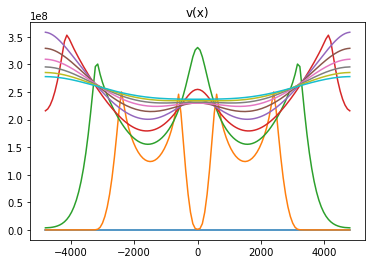

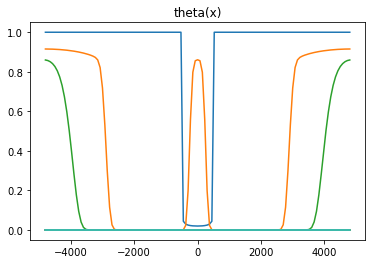

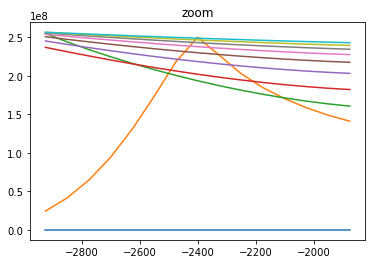

In [252]:
##Affichage
pas = max(1, N//10)

for n in range(0, N, pas):
    plt.plot(x, np.exp(Phi[n]))
plt.title('v(x)')
plt.show()

for n in range(0, N, pas):
    plt.plot(x, np.exp(Nu[n]))
plt.title('theta(x)')
plt.show()

for n in range(0, N, pas):
    plt.plot(x[25:40], np.exp(Phi[n])[25:40])
plt.title('zoom')
plt.show()

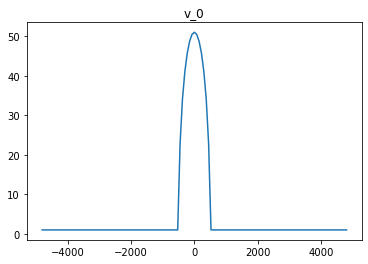

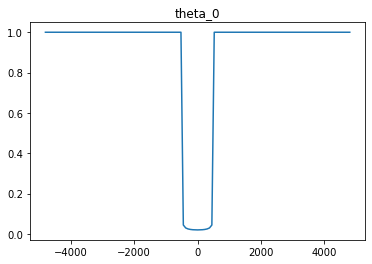

In [248]:
plt.plot(x, CIv)
plt.title('v_0')
plt.show()
plt.plot(x, CItheta)
plt.title('theta_0')
plt.show()